In [1]:
# Step 1: This step loads project paths and checks dataset availability
from paths import PROJECT_ROOT, DATA_DIR, OUTPUTS_DIR, ARTIFACTS_DIR
import os

DATA_PATH = os.path.join(DATA_DIR, "malicious_phish.csv")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR    :", DATA_DIR)
print("OUTPUTS_DIR :", OUTPUTS_DIR)
print("ARTIFACTS_DIR:", ARTIFACTS_DIR)

if os.path.exists(DATA_PATH):
    print(f"Dataset found at: {DATA_PATH}")
else:
    print(f"Dataset not found! Please place malicious_phish.csv inside: {DATA_DIR}")


PROJECT_ROOT: c:\Users\Vanshika Bohra\Desktop\MLPROJECT
DATA_DIR    : c:\Users\Vanshika Bohra\Desktop\MLPROJECT\data
OUTPUTS_DIR : c:\Users\Vanshika Bohra\Desktop\MLPROJECT\outputs
ARTIFACTS_DIR: c:\Users\Vanshika Bohra\Desktop\MLPROJECT\artifacts
PROJECT_ROOT: c:\Users\Vanshika Bohra\Desktop\MLPROJECT
DATA_DIR    : c:\Users\Vanshika Bohra\Desktop\MLPROJECT\data
OUTPUTS_DIR : c:\Users\Vanshika Bohra\Desktop\MLPROJECT\outputs
ARTIFACTS_DIR: c:\Users\Vanshika Bohra\Desktop\MLPROJECT\artifacts
Dataset found at: c:\Users\Vanshika Bohra\Desktop\MLPROJECT\data\malicious_phish.csv


In [6]:
# Step 2: This step defines helper functions for logging and saving artifacts
import os, pickle
from paths import ARTIFACTS_DIR, OUTPUTS_DIR

def log(msg, level="INFO"):
    tags = {"INFO": "[INFO]", "OK": "[OK ]", "WARN": "[WARN]", "ERR": "[ERR]"}
    print(f"{tags.get(level, '[INFO]')} {msg}")

def artifact_path(name, ext=".pkl"):
    return os.path.join(ARTIFACTS_DIR, f"{name}{ext}")

def save_artifact(name, obj, ext=".pkl"):
    path = artifact_path(name, ext)
    with open(path, "wb") as f:
        pickle.dump(obj, f)
    log(f"Saved artifact '{name}' to {path}", "OK")
    return path

def load_artifact(name, ext=".pkl"):
    path = artifact_path(name, ext)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Artifact not found: {path}")
    with open(path, "rb") as f:
        obj = pickle.load(f)
    log(f"Loaded artifact '{name}' from {path}", "OK")
    return obj

def try_load_artifact(name, ext=".pkl"):
    path = artifact_path(name, ext)
    if not os.path.exists(path):
        log(f"Artifact not found (optional): {path}", "WARN")
        return None
    with open(path, "rb") as f:
        obj = pickle.load(f)
    log(f"Loaded artifact '{name}' from {path}", "OK")
    return obj

def write_report(filename, lines):
    path = os.path.join(OUTPUTS_DIR, filename)
    text = "\n".join(lines)
    with open(path, "w") as f:
        f.write(text)
    log(f"Wrote report to {path}", "OK")
    return path


In [3]:
# Step 3: This step canonicalizes URLs and builds lexical features with audited splits
import os, json, math, time, re
from urllib.parse import urlsplit
from collections import Counter

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from paths import DATA_DIR, OUTPUTS_DIR, ARTIFACTS_DIR

start = time.time()
log("Starting lexical feature extraction (canonicalized URLs).")

data_csv = os.path.join(DATA_DIR, "malicious_phish.csv")
df_raw = pd.read_csv(data_csv)

n_rows_raw = int(len(df_raw))
label_counts_raw = {}
if "type" in df_raw.columns:
    label_counts_raw = df_raw["type"].astype(str).value_counts().to_dict()

df = df_raw.drop_duplicates().dropna(subset=["url", "type"])
df["url"] = df["url"].astype(str).str.strip()
df["type"] = df["type"].astype(str).str.strip()
df = df[df["url"] != ""]
df = df.reset_index(drop=True)

n_rows_clean = int(len(df))
label_counts_clean = df["type"].astype(str).value_counts().to_dict()

log(f"Rows raw: {n_rows_raw}, after cleaning: {n_rows_clean}", "INFO")
log(f"Label counts (raw): {label_counts_raw}", "INFO")
log(f"Label counts (clean): {label_counts_clean}", "INFO")

_expected_labels = {"benign", "defacement", "phishing", "malware"}
present_labels = set(df["type"].astype(str).unique())
extra_labels = present_labels - _expected_labels
missing_labels = _expected_labels - present_labels

if extra_labels:
    raise ValueError(f"Unexpected labels present in dataset: {sorted(extra_labels)}")
if missing_labels:
    log(f"Missing expected labels: {sorted(missing_labels)}", "WARN")

canon_fail = {"count": 0}

def canonicalize(u: str) -> str:
    try:
        u = (u or "").strip()
        p = urlsplit(u)
        scheme = (p.scheme or "").lower()
        netloc = p.netloc
        if "@" in netloc:
            userinfo, hostport = netloc.rsplit("@", 1)
            netloc_low = f"{userinfo}@{hostport.lower()}"
        else:
            netloc_low = netloc.lower()
        host_only = netloc_low
        port = None
        if ":" in netloc_low and netloc_low.count(":") == 1 and "]" not in netloc_low:
            host_only, port = netloc_low.split(":")
        elif netloc_low.startswith("[") and "]" in netloc_low:
            host_only, _, tail = netloc_low.partition("]")
            rest = tail[1:] if tail.startswith(":") else ""
            port = rest if rest else None
            host_only = host_only + "]"
        if (scheme == "http" and port == "80") or (scheme == "https" and port == "443"):
            netloc_final = host_only
        else:
            netloc_final = netloc_low
        path = re.sub(r"/{2,}", "/", p.path or "/")
        query = p.query or ""
        out = f"{scheme}://{netloc_final}{path}"
        if query:
            out += f"?{query}"
        return out
    except Exception:
        canon_fail["count"] += 1
        return u or ""

df["url_canon"] = df["url"].map(canonicalize)
n_canon_fail = int(canon_fail["count"])
if n_canon_fail > 0:
    frac = n_canon_fail / max(len(df), 1)
    log(f"Canonicalization failures: {n_canon_fail} ({frac:.6%} of rows)", "WARN")
else:
    log("Canonicalization failures: 0", "INFO")

TOKENS = ["login","verify","secure","update","bank","paypal","free","click","confirm","account","signin","payment","billing"]
SPECIALS = "-_@?%=&.:/"

def shannon_entropy(s: str) -> float:
    if not s:
        return 0.0
    p, n = Counter(s), len(s)
    return -sum((c / n) * math.log2(c / n) for c in p.values())

feat_fail = {"count": 0}

def extract_features(u: str) -> dict:
    try:
        parts = urlsplit(u)
        host = parts.hostname or ""
        path = parts.path or ""
        query = parts.query or ""
        total_len = len(u)
        digits = sum(ch.isdigit() for ch in u)
        specials = sum(ch in SPECIALS for ch in u)
        uppers = sum(ch.isupper() for ch in u)
        low = u.lower()
        token_flags = {f"tok_{t}": int(t in low) for t in TOKENS}
        sus_token_hits = int(sum(token_flags.values()))
        return {
            "url": u,
            "len_total": total_len,
            "len_host": len(host),
            "len_path": len(path),
            "len_query": len(query),
            "count_digits": digits,
            "count_specials": specials,
            "ratio_digits": digits / (total_len or 1),
            "ratio_specials": specials / (total_len or 1),
            "ratio_upper": uppers / (total_len or 1),
            "entropy_total": shannon_entropy(u),
            "entropy_host": shannon_entropy(host),
            "has_ipv4": int(bool(re.fullmatch(r"(?:\d{1,3}\.){3}\d{1,3}", host))),
            "has_at": int("@" in u),
            "has_https": int(u.startswith("https://")),
            "count_dots_host": host.count("."),
            "sus_token_hits": sus_token_hits,
            **token_flags,
        }
    except Exception:
        feat_fail["count"] += 1
        z = {
            "url": u,
            "len_total": 0,
            "len_host": 0,
            "len_path": 0,
            "len_query": 0,
            "count_digits": 0,
            "count_specials": 0,
            "ratio_digits": 0.0,
            "ratio_specials": 0.0,
            "ratio_upper": 0.0,
            "entropy_total": 0.0,
            "entropy_host": 0.0,
            "has_ipv4": 0,
            "has_at": 0,
            "has_https": 0,
            "count_dots_host": 0,
            "sus_token_hits": 0,
        }
        for t in TOKENS:
            z[f"tok_{t}"] = 0
        return z

urls = df["url_canon"]
feat_rows = []
for i, u in enumerate(urls, 1):
    feat_rows.append(extract_features(u))
    if i % 100_000 == 0:
        log(f"Processed {i:,} URLs...", "INFO")

features = pd.DataFrame(feat_rows, index=df.index)
data_feat = pd.concat([features, df["type"].rename("label")], axis=1)
cols = ["url"] + sorted([c for c in data_feat.columns if c not in {"url", "label"}]) + ["label"]
data_feat = data_feat[cols]

if len(data_feat) != len(df):
    raise ValueError(f"Row-count drift after feature build: df={len(df)}, data_feat={len(data_feat)}.")

n_feature_fail = int(feat_fail["count"])
if n_feature_fail > 0:
    frac = n_feature_fail / max(len(df), 1)
    log(f"Feature extraction failures: {n_feature_fail} ({frac:.6%} of rows)", "WARN")
else:
    log("Feature extraction failures: 0", "INFO")

labels = df["type"].astype(str).values
idx_all = np.arange(len(df))

train_idx, temp_idx = train_test_split(
    idx_all,
    test_size=0.30,
    random_state=42,
    stratify=labels
)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    random_state=42,
    stratify=labels[temp_idx]
)

idx = {
    "train": train_idx.tolist(),
    "val": val_idx.tolist(),
    "test": test_idx.tolist(),
}
save_artifact("clean_split_v1_indices", {"idx": idx})

overall_counts = pd.Series(labels).value_counts().to_dict()
train_counts = pd.Series(labels[train_idx]).value_counts().to_dict()
val_counts = pd.Series(labels[val_idx]).value_counts().to_dict()
test_counts = pd.Series(labels[test_idx]).value_counts().to_dict()

log(f"Features extracted: {len(cols) - 2} columns for {len(data_feat):,} URLs", "OK")
log(f"Split sizes → train={len(idx['train'])}, val={len(idx['val'])}, test={len(idx['test'])}", "INFO")
log(f"Class counts overall: {overall_counts}", "INFO")
log(f"Class counts train:   {train_counts}", "INFO")
log(f"Class counts val:     {val_counts}", "INFO")
log(f"Class counts test:    {test_counts}", "INFO")

processed_dir = os.path.join(DATA_DIR, "processed")
metrics_dir = os.path.join(OUTPUTS_DIR, "metrics")
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

for split, id_list in [("train", idx["train"]), ("val", idx["val"]), ("test", idx["test"])]:
    df_split = data_feat.iloc[id_list].copy()
    out_path = os.path.join(processed_dir, f"lexical_features_{split}.csv")
    df_split.to_csv(out_path, index=False)
    log(f"Saved {split} features → {out_path}", "OK")

summary = {
    "n_rows_raw": n_rows_raw,
    "n_rows_clean": n_rows_clean,
    "label_counts_raw": label_counts_raw,
    "label_counts_clean": label_counts_clean,
    "present_labels": sorted(present_labels),
    "missing_labels": sorted(missing_labels),
    "n_rows": int(len(data_feat)),
    "n_features": int(len(cols) - 2),
    "tokens": TOKENS,
    "columns_sample": cols[:10] + ["..."] + cols[-10:],
    "n_canon_fail": n_canon_fail,
    "n_feature_fail": n_feature_fail,
    "split_sizes": {
        "train": len(idx["train"]),
        "val": len(idx["val"]),
        "test": len(idx["test"]),
    },
    "class_counts": {
        "overall": overall_counts,
        "train": train_counts,
        "val": val_counts,
        "test": test_counts,
    },
    "elapsed_sec": round(time.time() - start, 2),
}

summary_path = os.path.join(metrics_dir, "02_lexical_features_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

log(f"Wrote summary → {summary_path}", "OK")
log(f"Lexical feature extraction complete in {summary['elapsed_sec']}s", "OK")


[INFO] Starting lexical feature extraction (canonicalized URLs).
[INFO] Rows raw: 651191, after cleaning: 641125
[INFO] Label counts (raw): {'benign': 428103, 'defacement': 96457, 'phishing': 94111, 'malware': 32520}
[INFO] Label counts (clean): {'benign': 428080, 'defacement': 95308, 'phishing': 94092, 'malware': 23645}
[INFO] Canonicalization failures: 0
[INFO] Processed 100,000 URLs...
[INFO] Processed 200,000 URLs...
[INFO] Processed 300,000 URLs...
[INFO] Processed 400,000 URLs...
[INFO] Processed 500,000 URLs...
[INFO] Processed 600,000 URLs...
[INFO] Feature extraction failures: 0
[OK ] Saved artifact 'clean_split_v1_indices' to c:\Users\Vanshika Bohra\Desktop\MLPROJECT\artifacts\clean_split_v1_indices.pkl
[OK ] Features extracted: 29 columns for 641,125 URLs
[INFO] Split sizes → train=448787, val=96169, test=96169
[INFO] Class counts overall: {'benign': 428080, 'defacement': 95308, 'phishing': 94092, 'malware': 23645}
[INFO] Class counts train:   {'benign': 299656, 'defacement'

In [7]:
# Step 4: This step generates EDA plots and summary statistics
from pathlib import Path
import os, json
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from paths import DATA_DIR, OUTPUTS_DIR

sns.set(style="whitegrid")

metrics_dir = os.path.join(OUTPUTS_DIR, "metrics")
eda_dir = os.path.join(OUTPUTS_DIR, "eda")
os.makedirs(metrics_dir, exist_ok=True)
os.makedirs(eda_dir, exist_ok=True)

csv_path = os.path.join(DATA_DIR, "malicious_phish.csv")
raw = pd.read_csv(csv_path)
raw["type"] = raw["type"].astype(str).str.strip()

proc_dir = os.path.join(DATA_DIR, "processed")
feat_tr = pd.read_csv(os.path.join(proc_dir, "lexical_features_train.csv"))
feat_va = pd.read_csv(os.path.join(proc_dir, "lexical_features_val.csv"))
feat_te = pd.read_csv(os.path.join(proc_dir, "lexical_features_test.csv"))
feat = pd.concat([feat_tr, feat_va, feat_te], axis=0, ignore_index=True)

classes = ["benign", "defacement", "phishing", "malware"]
palette = {
    "benign": "#4C72B0",
    "defacement": "#DD8452",
    "phishing": "#55A868",
    "malware": "#C44E52",
}

raw_counts = raw["type"].value_counts().reindex(classes, fill_value=0)
clean_counts = feat["label"].value_counts().reindex(classes, fill_value=0)

def bar_pct(counts, title, filename):
    total = counts.sum()
    pct = [(counts[c] / total * 100 if total > 0 else 0.0) for c in classes]
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(classes, pct, color=[palette[c] for c in classes])
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Percentage (%)")
    for b, v in zip(bars, pct):
        ax.text(b.get_x() + b.get_width() / 2, v + 0.3, f"{v:.1f}", ha="center", va="bottom", fontsize=8)
    fig.tight_layout()
    fig.savefig(os.path.join(eda_dir, filename), dpi=130)
    plt.close(fig)

bar_pct(raw_counts, "Label Distribution — Raw (%)", "01_raw_labels.png")
bar_pct(clean_counts, "Label Distribution — Clean (%)", "02_clean_labels.png")

comp = pd.DataFrame({
    "class": classes,
    "Raw (%)": [(raw_counts[c] / raw_counts.sum() * 100 if raw_counts.sum() > 0 else 0.0) for c in classes],
    "Clean (%)": [(clean_counts[c] / clean_counts.sum() * 100 if clean_counts.sum() > 0 else 0.0) for c in classes],
})
comp_m = comp.melt(id_vars="class", var_name="Dataset", value_name="pct")
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(data=comp_m, x="class", y="pct", hue="Dataset",
            hue_order=["Raw (%)", "Clean (%)"],
            palette=["#999999", "#4C72B0"], ax=ax)
ax.set_title("Label Distribution — Raw vs Clean (%)")
ax.set_xlabel("Class")
ax.set_ylabel("Percentage (%)")
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f", fontsize=8)
fig.tight_layout()
fig.savefig(os.path.join(eda_dir, "03_raw_vs_clean.png"), dpi=130)
plt.close(fig)

core_feats = ["len_total", "count_digits", "ratio_specials", "entropy_total"]
pretty = {
    "len_total": "URL Length",
    "count_digits": "Digit Count",
    "ratio_specials": "Special Character Ratio",
    "entropy_total": "Entropy",
}

for f in core_feats:
    if f not in feat.columns:
        continue
    d = feat[["label", f]].copy()
    d[f] = d[f].clip(upper=d[f].quantile(0.99))
    plt.figure(figsize=(7, 4))
    sns.boxplot(
        data=d,
        x="label",
        y=f,
        hue="label",
        order=classes,
        palette=[palette[c] for c in classes],
        dodge=False,
        legend=False,
    )
    plt.title(f"{pretty[f]} by Class (Clipped)")
    plt.xlabel("Class")
    plt.ylabel(pretty[f])
    plt.tight_layout()
    plt.savefig(os.path.join(eda_dir, f"04_box_{f}.png"), dpi=130)
    plt.close()

if "has_ipv4" in feat.columns:
    ipv4_pct = feat.groupby("label")["has_ipv4"].mean().reindex(classes, fill_value=0) * 100.0
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(classes, ipv4_pct.values, color=[palette[c] for c in classes])
    ax.set_title("URLs with IPv4 in Host (%)")
    ax.set_xlabel("Class")
    ax.set_ylabel("Percentage (%)")
    for b, v in zip(bars, ipv4_pct.values):
        ax.text(b.get_x() + b.get_width() / 2, v + 0.3, f"{v:.1f}", ha="center", va="bottom", fontsize=8)
    fig.tight_layout()
    fig.savefig(os.path.join(eda_dir, "05_ipv4.png"), dpi=130)
    plt.close(fig)

num_cols = [c for c in feat.columns if c not in {"url", "label"} and np.issubdtype(feat[c].dtype, np.number)]
corr = feat[num_cols].corr().clip(-1, 1)
plt.figure(figsize=(min(1 + 0.4 * len(num_cols), 14), min(1 + 0.4 * len(num_cols), 14)))
sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f", cbar=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.savefig(os.path.join(eda_dir, "06_corr_heatmap.png"), dpi=130)
plt.close()

if "len_total" in feat.columns and "entropy_total" in feat.columns:
    d_sc = feat[["label", "len_total", "entropy_total"]].copy()
    d_sc["len_total"] = d_sc["len_total"].clip(upper=d_sc["len_total"].quantile(0.99))
    d_sc["entropy_total"] = d_sc["entropy_total"].clip(upper=d_sc["entropy_total"].quantile(0.99))
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        data=d_sc.sample(min(len(d_sc), 50000), random_state=42),
        x="len_total",
        y="entropy_total",
        hue="label",
        hue_order=classes,
        palette=[palette[c] for c in classes],
        alpha=0.1,
        s=8,
    )
    plt.title("URL Length vs Entropy (Clipped, Sampled)")
    plt.xlabel("URL Length (clipped)")
    plt.ylabel("Entropy (clipped)")
    plt.tight_layout()
    plt.savefig(os.path.join(eda_dir, "07_scatter_len_entropy.png"), dpi=130)
    plt.close()

if "entropy_total" in feat.columns:
    df_e = feat[["label", "entropy_total"]].copy()
    df_e["entropy_total"] = df_e["entropy_total"].clip(upper=df_e["entropy_total"].quantile(0.99))
    plt.figure(figsize=(7, 4))
    sns.histplot(
        data=df_e,
        x="entropy_total",
        hue="label",
        hue_order=classes,
        stat="density",
        common_norm=False,
        palette=[palette[c] for c in classes],
        element="step",
        alpha=0.5,
    )
    plt.title("Entropy Distribution by Class")
    plt.xlabel("Entropy")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.savefig(os.path.join(eda_dir, "08_entropy.png"), dpi=130)
    plt.close()

if "len_total" in feat.columns:
    df_l = feat[["label", "len_total"]].copy()
    df_l["len_total"] = df_l["len_total"].clip(upper=df_l["len_total"].quantile(0.99))
    plt.figure(figsize=(7, 4))
    sns.histplot(
        data=df_l,
        x="len_total",
        hue="label",
        hue_order=classes,
        stat="density",
        common_norm=False,
        palette=[palette[c] for c in classes],
        element="step",
        alpha=0.5,
    )
    plt.title("URL Length Distribution by Class")
    plt.xlabel("URL Length")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.savefig(os.path.join(eda_dir, "09_length.png"), dpi=130)
    plt.close()

token_cols = [c for c in feat.columns if c.startswith("tok_")]
token_summary = {}
if token_cols:
    token_pct = feat.groupby("label")[token_cols].mean() * 100.0
    rows = []
    for lab in classes:
        if lab not in token_pct.index:
            continue
        for tok in token_cols:
            val = float(token_pct.loc[lab, tok])
            rows.append({"label": lab, "token": tok.replace("tok_", ""), "pct": val})
            token_summary.setdefault(lab, {})[tok.replace("tok_", "")] = val
    tk = pd.DataFrame(rows)
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(
        data=tk,
        x="token",
        y="pct",
        hue="label",
        hue_order=classes,
        palette=[palette[c] for c in classes],
    )
    ax.set_title("Suspicious Token Frequency by Class (%)")
    ax.set_xlabel("Token")
    ax.set_ylabel("Percentage (%)")
    for p in ax.patches:
        h = p.get_height()
        if h > 0:
            ax.annotate(f"{h:.1f}", (p.get_x() + p.get_width() / 2, h + 0.3),
                        ha="center", va="bottom", fontsize=7)
    plt.tight_layout()
    plt.savefig(os.path.join(eda_dir, "10_tokens.png"), dpi=130)
    plt.close()

feature_stats = {}
for f in core_feats:
    if f not in feat.columns:
        continue
    stats_f = {}
    for lab in classes:
        s = feat.loc[feat["label"] == lab, f]
        if len(s) == 0:
            continue
        stats_f[lab] = {
            "mean": float(s.mean()),
            "median": float(s.median()),
            "std": float(s.std()),
        }
    feature_stats[f] = stats_f

raw_total = raw_counts.sum() if raw_counts.sum() > 0 else 1.0
clean_total = clean_counts.sum() if clean_counts.sum() > 0 else 1.0

eda_summary = {
    "n_rows_raw": int(len(raw)),
    "n_rows_clean": int(len(feat)),
    "label_pct_raw": {c: float(raw_counts[c] / raw_total * 100) for c in classes},
    "label_pct_clean": {c: float(clean_counts[c] / clean_total * 100) for c in classes},
    "feature_stats_per_class": feature_stats,
    "token_pct_per_class": token_summary,
}

with open(os.path.join(metrics_dir, "03_eda_summary.json"), "w") as f:
    json.dump(eda_summary, f, indent=2)

try:
    log("EDA plots and summary generated.", "OK")
except Exception:
    print("EDA plots and summary generated.")

[OK ] EDA plots and summary generated.


[WARN] PermissionError writing c:\Users\Vanshika Bohra\Desktop\MLPROJECT\outputs\metrics\Features.md; falling back to direct write (file may be open in an editor).
[INFO] ▶ Logistic Regression — tuning (tiny GridSearchCV) ...
[OK ] ✓ Logistic Regression best C = 2.0 (tune 15.3s). Retraining on full train...
[OK ] ✓ Logistic Regression trained in 16.5s
[INFO]   • Predicting ...
[INFO]   • Predicting ...
[INFO]   • Predicting ...
[INFO] ▶ Random Forests — tuning (tiny GridSearchCV) ...
[OK ] ✓ Random Forests best params = {'max_depth': 20, 'n_estimators': 200} (tune 55.6s). Retraining on full train...
[OK ] ✓ Random Forests trained in 40.5s
[INFO]   • Predicting ...
[INFO]   • Predicting ...
[INFO]   • Predicting ...
[INFO] ▶ Neural Network (MLP) — training ...
[OK ] ✓ Neural Network (MLP) trained in 248.3s
[WARN] PermissionError writing c:\Users\Vanshika Bohra\Desktop\MLPROJECT\outputs\metrics\08_models_supervised_summary.json; falling back to direct write (file may be open in an editor

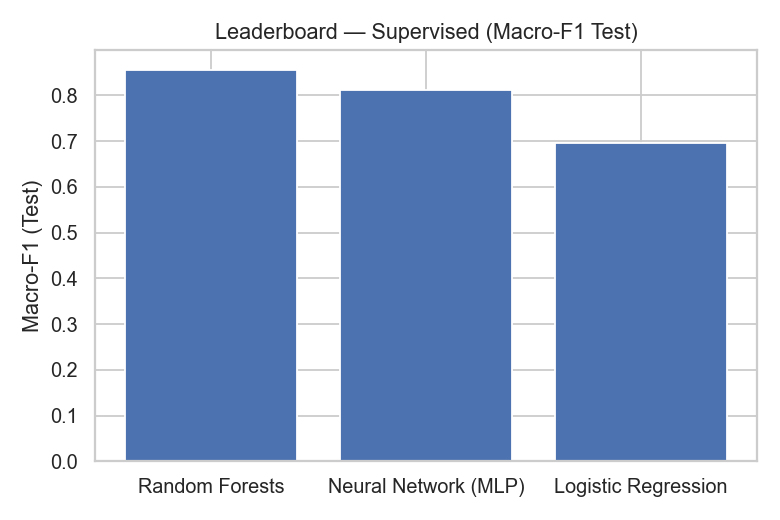

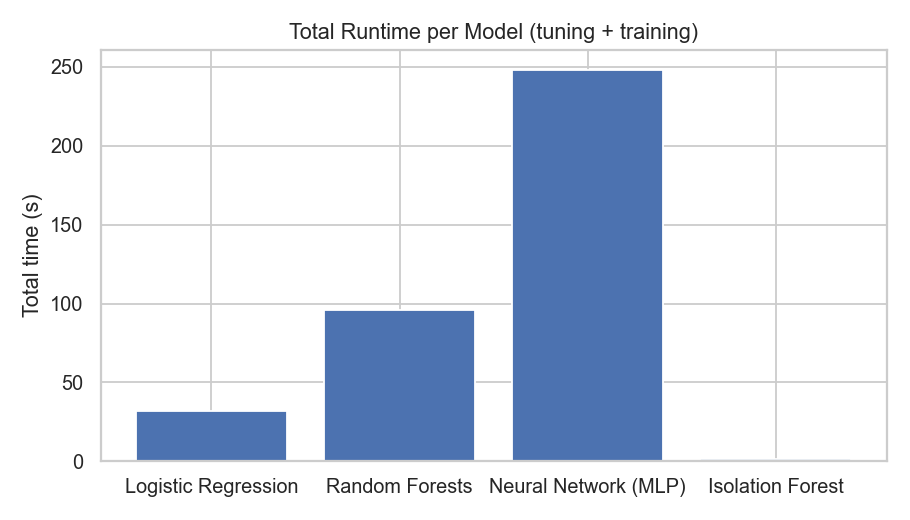

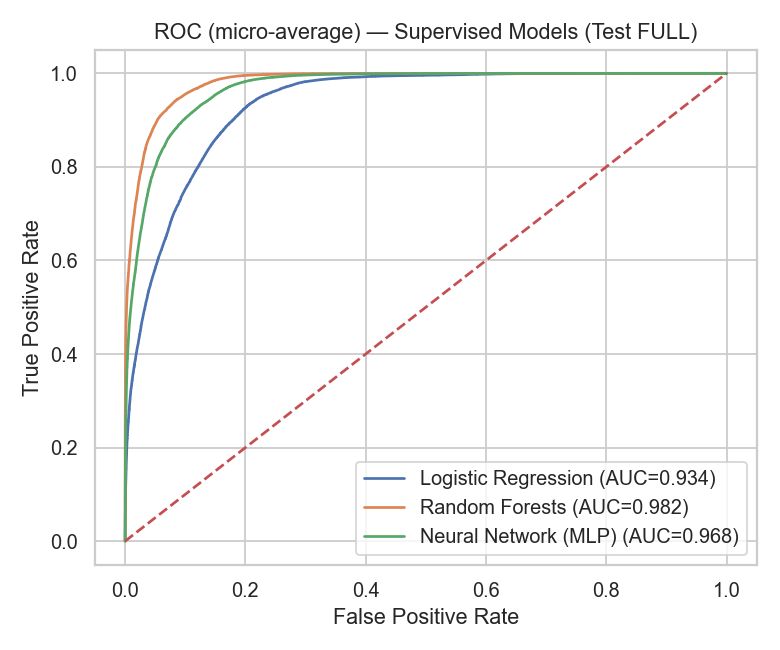

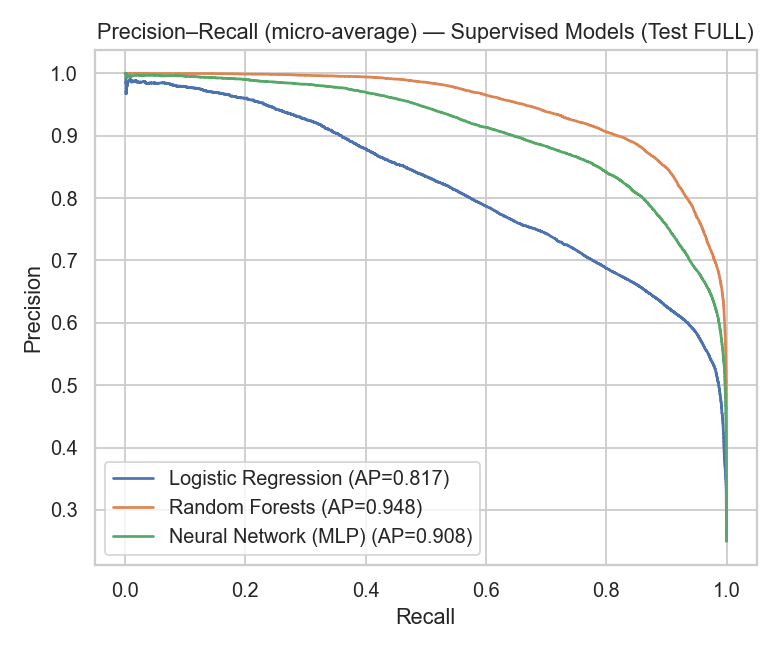

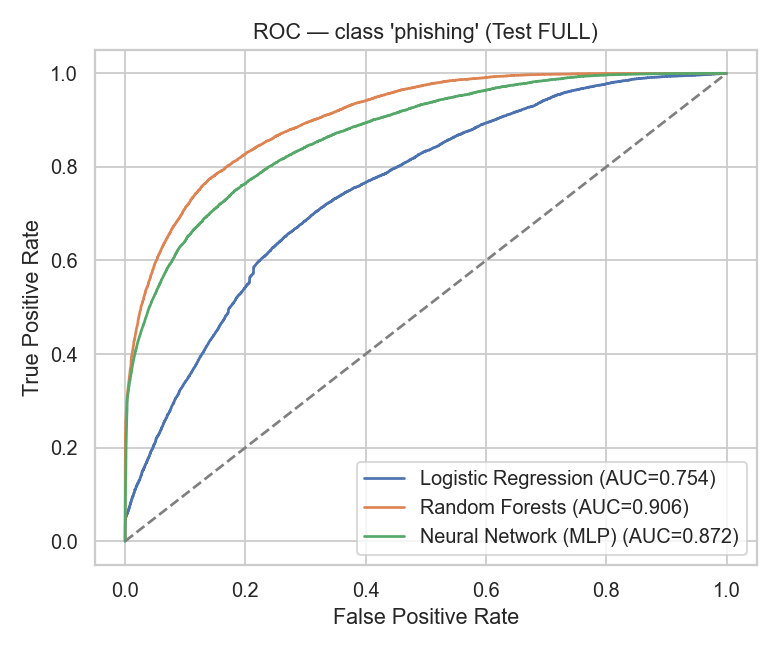

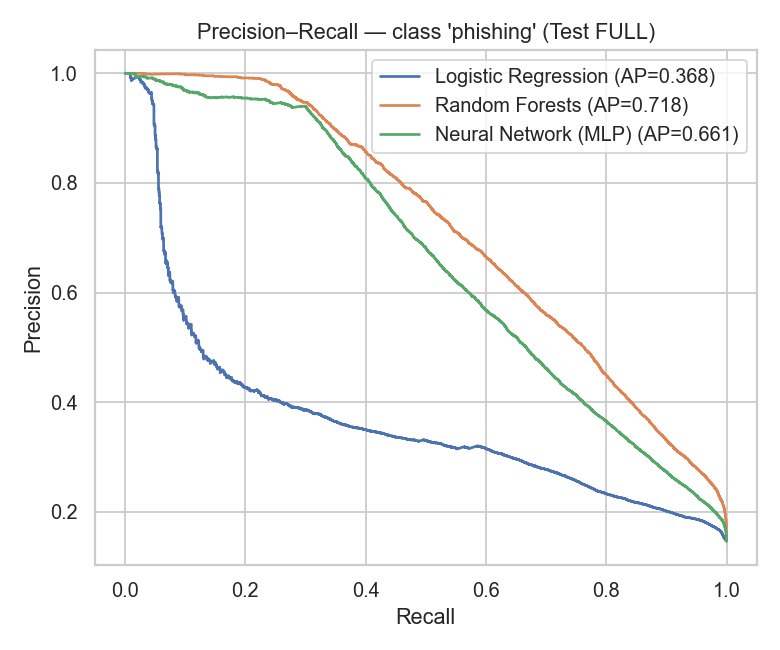

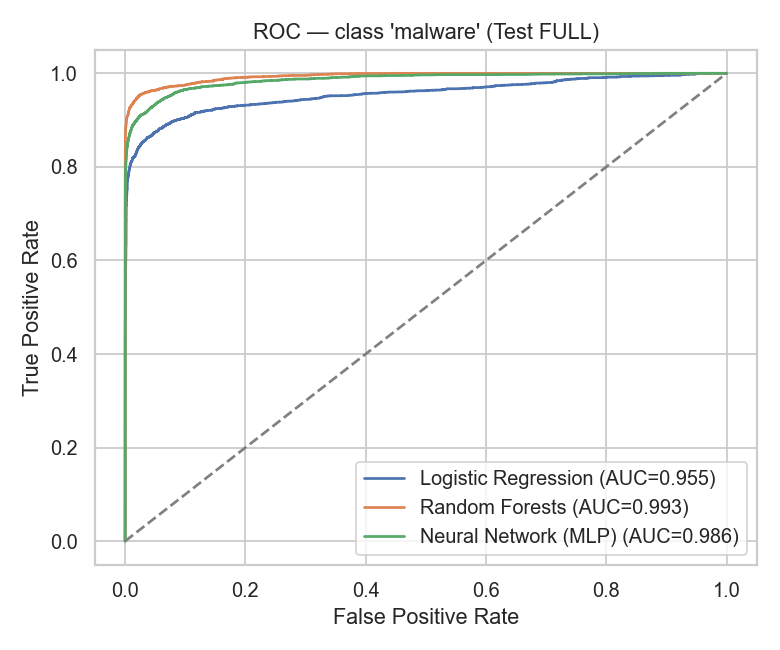

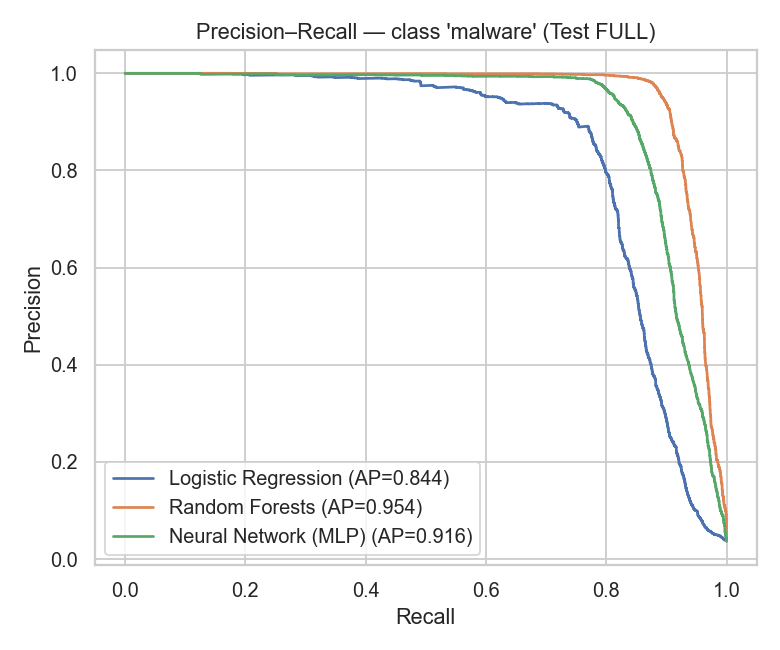

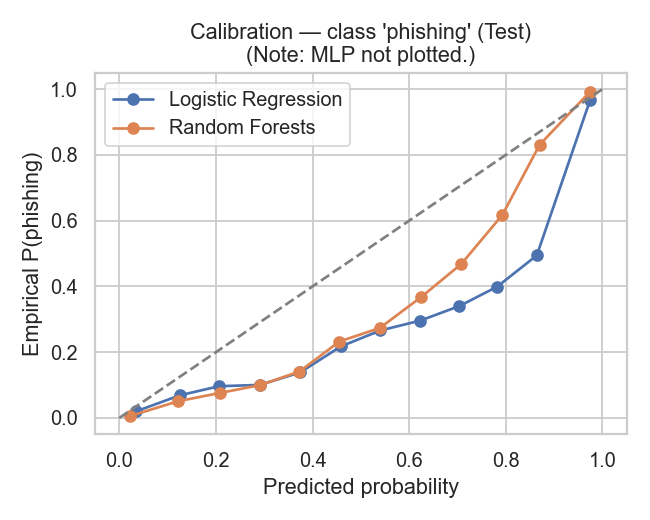

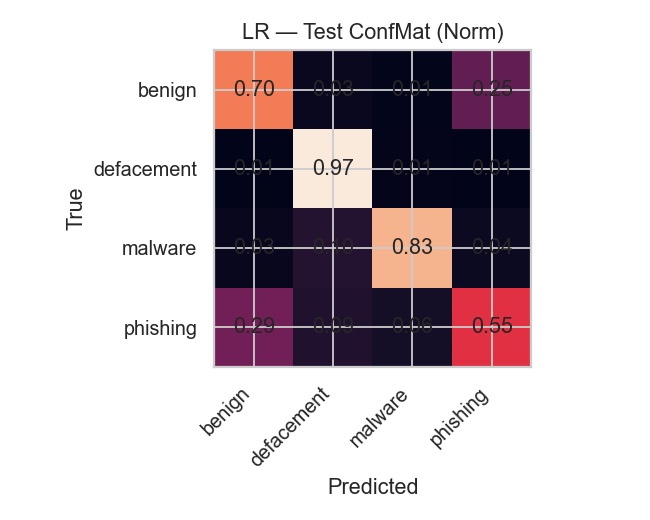

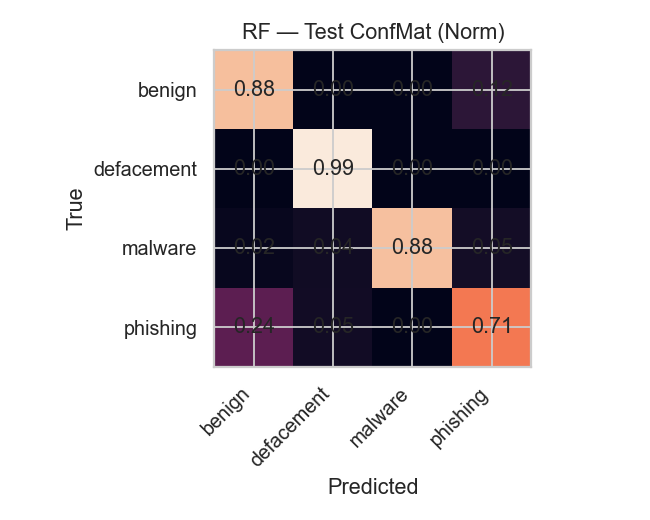

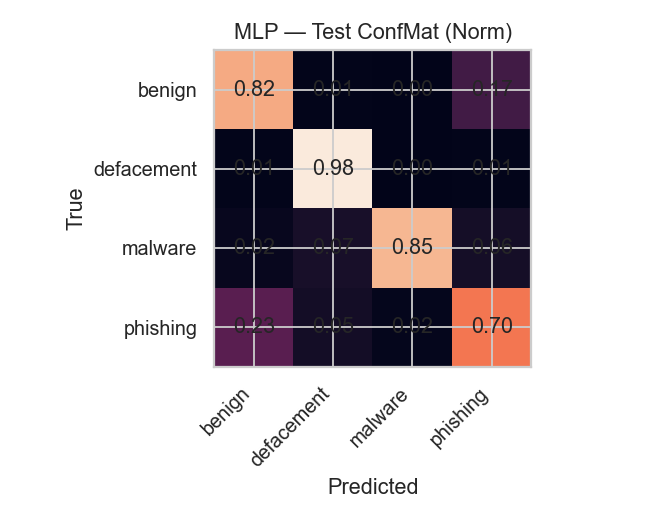

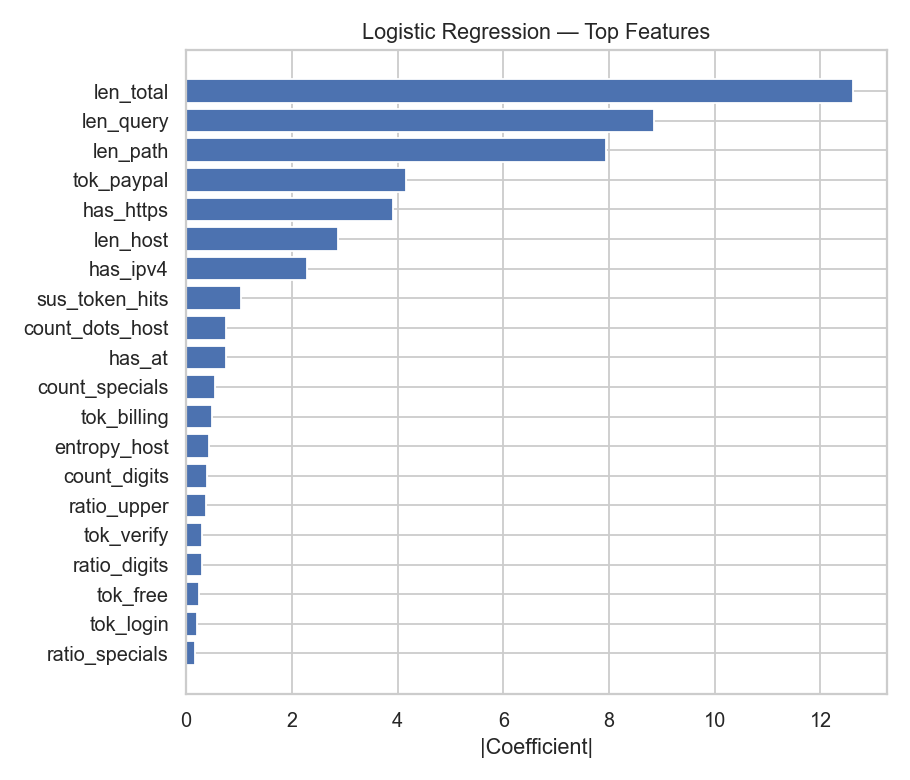

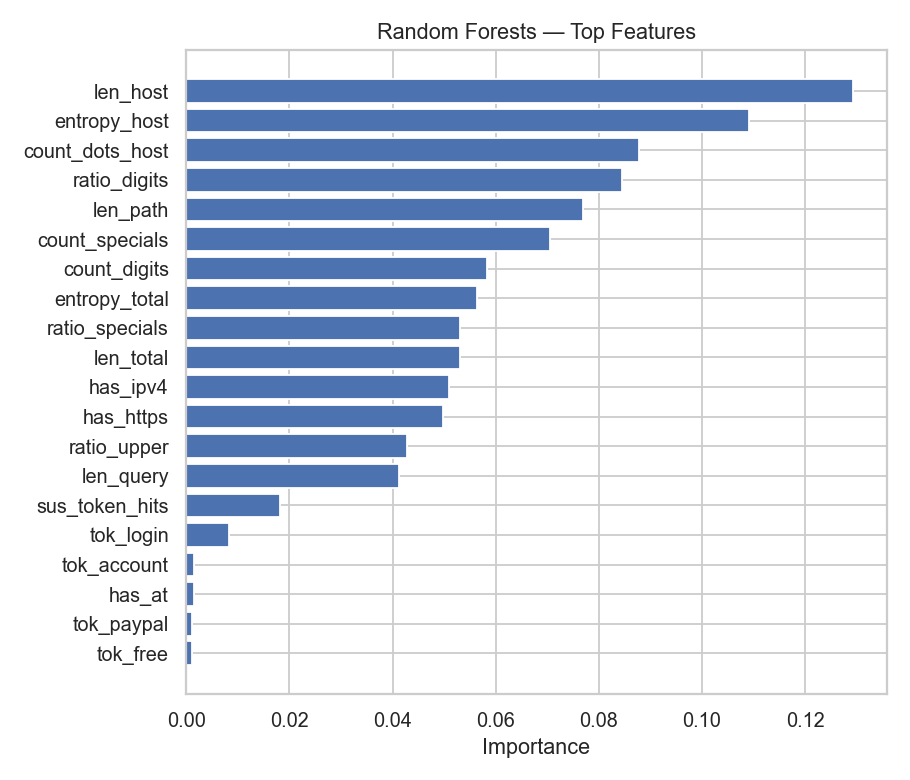

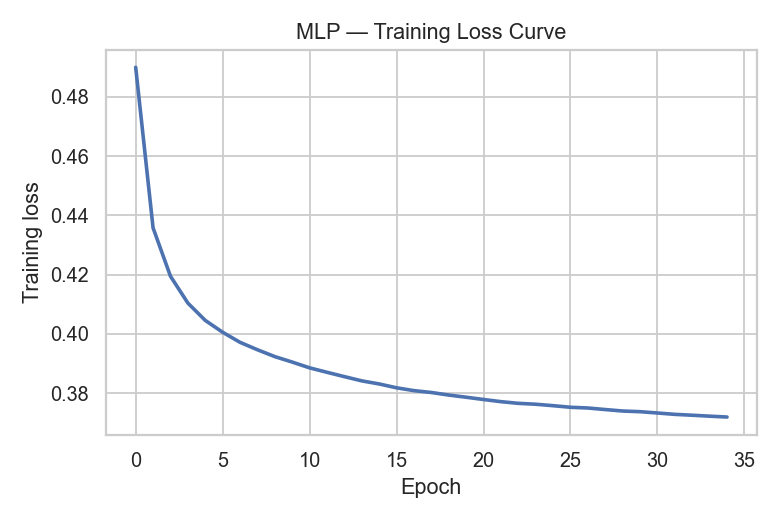

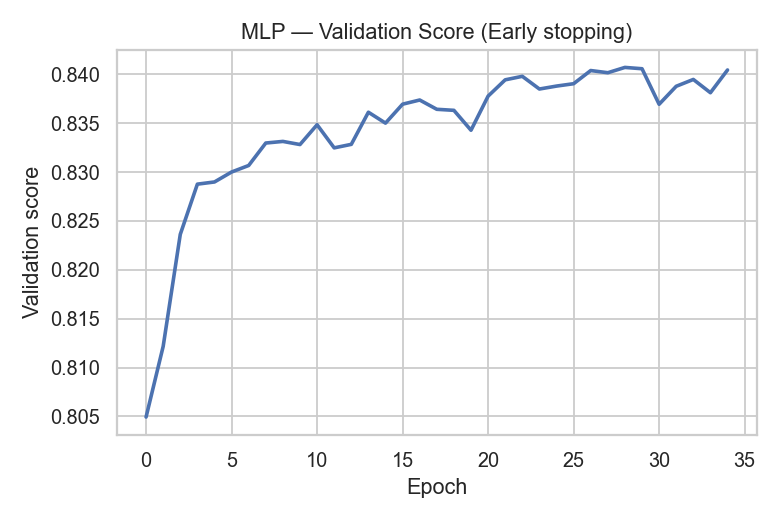

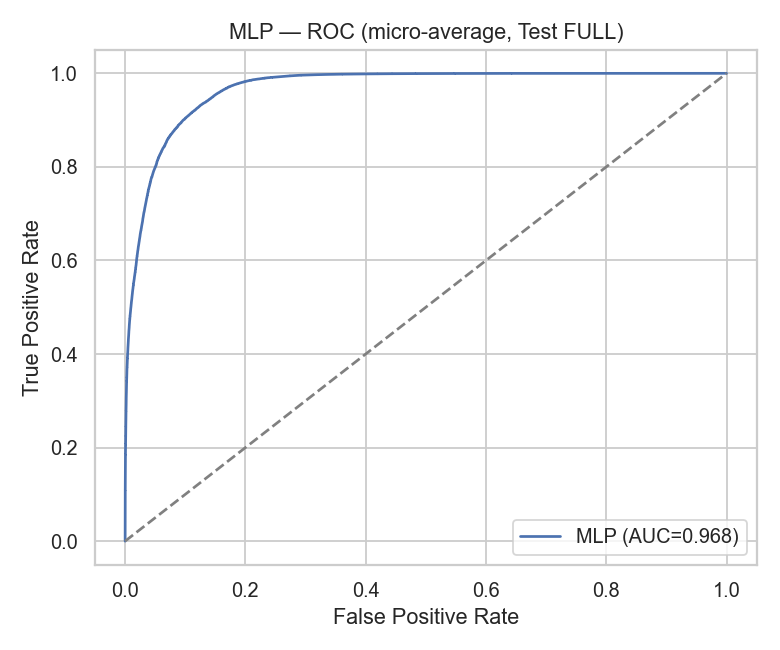

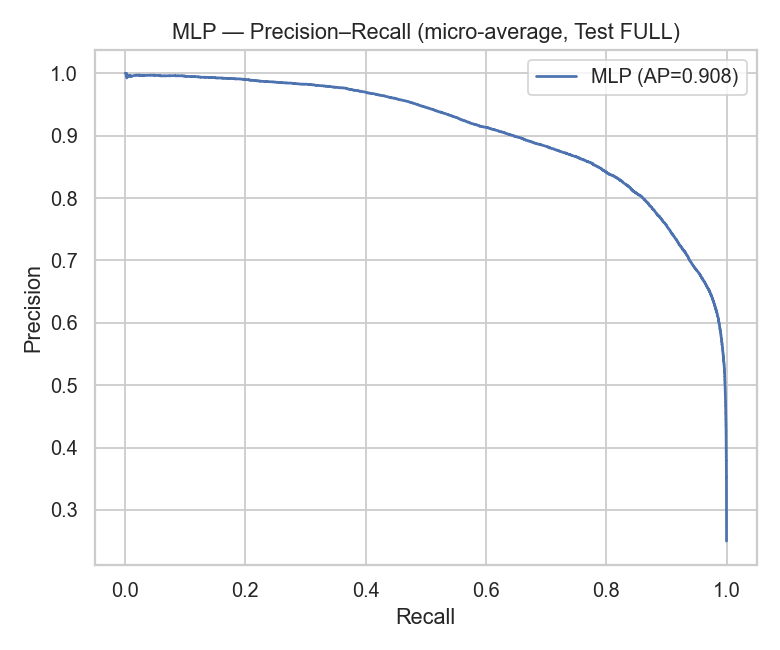

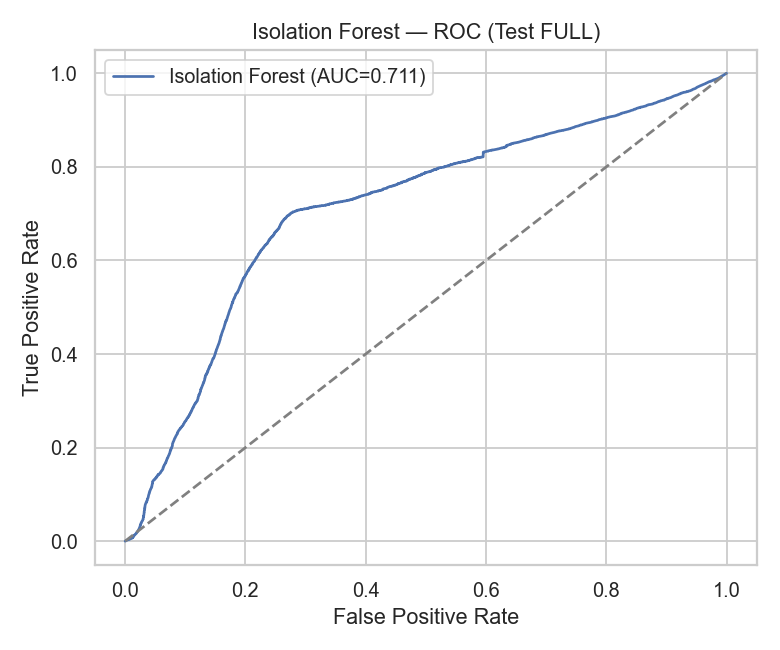

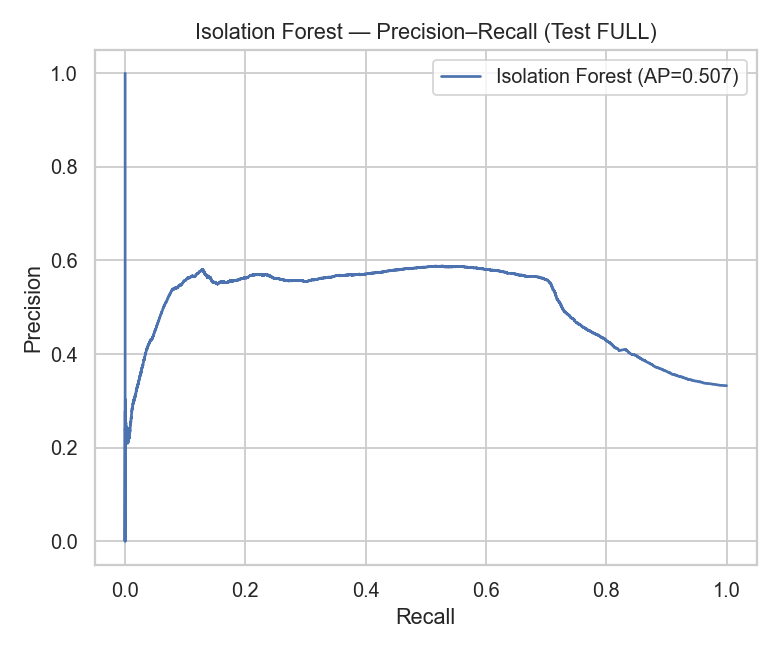

[OK ] ✓ Done — LR / RF / MLP + IF, with per-class metrics, full-test ROC/PR, feature file hashes, security_recall_score, and binary threshold appendix.


In [5]:
# =======
# STEP 5
# =======

from pathlib import Path
import json, os, sys, time, joblib, random, tempfile, platform, hashlib
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score,
    roc_curve, auc, average_precision_score, precision_recall_curve
)
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from IPython.display import display, HTML, Image

import paths as _paths  # uses paths.py (DATA_DIR, OUTPUTS_DIR, CONFIG, etc.)

# -----------------------
# Paths / global settings
# -----------------------

DATA_DIR = Path(_paths.DATA_DIR)
OUTPUTS_DIR = Path(_paths.OUTPUTS_DIR)
CONFIG = getattr(_paths, "CONFIG", {"dataset_filename": "malicious_phish.csv", "random_seed": 42})

PROJECT_ROOT = DATA_DIR.parent
DATA_PROCESSED_DIR = DATA_DIR / "processed"
OUTPUT_METRICS_DIR = OUTPUTS_DIR / "metrics"
OUTPUT_PREDS_DIR = OUTPUTS_DIR / "predictions"
MODELS_DIR = Path(getattr(_paths, "MODELS_DIR", PROJECT_ROOT / "models"))
GRAPHS_DIR = Path(getattr(_paths, "GRAPHS_DIR", PROJECT_ROOT / "graphs"))
GRAPHS_CONF_DIR = Path(getattr(_paths, "GRAPHS_CONF_DIR", GRAPHS_DIR / "confusion_matrices"))
GRAPHS_ROC_DIR = Path(getattr(_paths, "GRAPHS_ROC_DIR", GRAPHS_DIR / "roc_curves"))
GRAPHS_FEAT_DIR = Path(getattr(_paths, "GRAPHS_FEAT_DIR", GRAPHS_DIR / "feature_importance"))

for _p in [DATA_PROCESSED_DIR, OUTPUT_METRICS_DIR, OUTPUT_PREDS_DIR,
           MODELS_DIR, GRAPHS_DIR, GRAPHS_CONF_DIR, GRAPHS_ROC_DIR, GRAPHS_FEAT_DIR]:
    _p.mkdir(parents=True, exist_ok=True)


# -----------
# Logging / IO
# -----------

def _log(msg, level="INFO"):
    try:
        log(msg, level)  # uses your earlier helper if defined
    except Exception:
        tag = {"INFO": "[INFO]", "OK": "[OK ]", "WARN": "[WARN]", "ERR": "[ERR]"}.get(level, "[INFO]")
        print(f"{tag} {msg}")


def _atomic_write_text(path: Path, text: str):
    """
    Robust text writer:
    - writes via a temp file then replace()
    - falls back to direct write on PermissionError
    - always uses UTF-8 to avoid Windows cp1252 issues
    """
    fd, tmp = None, None
    try:
        fd, tmp = tempfile.mkstemp(dir=str(path.parent))
        tmp_path = Path(tmp)
        tmp_path.write_text(text, encoding="utf-8")
        tmp_path.replace(path)
    except PermissionError:
        _log(f"PermissionError writing {path}; falling back to direct write (file may be open in an editor).", "WARN")
        try:
            path.write_text(text, encoding="utf-8")
        except Exception as e:
            _log(f"Failed to write {path}: {e}", "ERR")
    finally:
        if fd is not None:
            try:
                os.close(fd)
            except Exception:
                pass


def _sha256_file(path: Path, chunk: int = 1 << 20) -> str:
    h = hashlib.sha256()
    with path.open("rb") as f:
        while True:
            b = f.read(chunk)
            if not b:
                break
            h.update(b)
    return h.hexdigest()


# ---------------
# Data / splits
# ---------------

SEED = int(CONFIG.get("random_seed", 42))
TUNE_CAP = 100_000
CV_SPLITS = 3
rng = np.random.default_rng(SEED)
random.seed(SEED)

p_train = DATA_PROCESSED_DIR / "lexical_features_train.csv"
p_val = DATA_PROCESSED_DIR / "lexical_features_val.csv"
p_test = DATA_PROCESSED_DIR / "lexical_features_test.csv"

df_tr = pd.read_csv(p_train)
df_va = pd.read_csv(p_val)
df_te = pd.read_csv(p_test)

y_tr = df_tr["label"].astype("string")
y_va = df_va["label"].astype("string")
y_te = df_te["label"].astype("string")

drop_cols = [c for c in ["label", "url"] if c in df_tr.columns]
X_tr = df_tr.drop(columns=drop_cols).select_dtypes(include=[np.number])
X_va = df_va.drop(columns=drop_cols).select_dtypes(include=[np.number])
X_te = df_te.drop(columns=drop_cols).select_dtypes(include=[np.number])

for nm, X in {"train": X_tr, "val": X_va, "test": X_te}.items():
    if not np.isfinite(X.to_numpy()).all():
        raise ValueError(f"{nm}: non-finite values in features (NaN/Inf). Fix upstream hygiene.")

labels = sorted(pd.concat([y_tr, y_va, y_te]).unique().tolist())
n_classes = len(labels)
counts_train = y_tr.value_counts().reindex(labels, fill_value=0).to_dict()
counts_val = y_va.value_counts().reindex(labels, fill_value=0).to_dict()
counts_test = y_te.value_counts().reindex(labels, fill_value=0).to_dict()

# feature list markdown
features_md = OUTPUT_METRICS_DIR / "Features.md"
feat_text = "# Features used (lexical: numeric)\n\n" + "\n".join([f"- {c}" for c in X_tr.columns])
_atomic_write_text(features_md, feat_text)


# ---------------------
# Generic model helpers
# ---------------------

def get_scores(model, X):
    """
    Returns (scores, proba_like):
    - for probabilistic models: (proba, proba)
    - for decision_function only: (scores_2d, None)
    - for others: one-hot predicted labels as scores, None
    """
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        return p, p
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        if s.ndim == 1:
            s = np.vstack([-s, s]).T
        return s, None
    y_pred = model.predict(X)
    class_to_idx = {c: i for i, c in enumerate(labels)}
    scores = np.zeros((len(y_pred), len(labels)))
    for i, lab in enumerate(y_pred):
        scores[i, class_to_idx.get(lab, 0)] = 1.0
    return scores, None


def brier_multiclass(y_true_str, proba, class_order):
    Y = label_binarize(y_true_str, classes=class_order)
    if proba is None or proba.shape != Y.shape:
        return None
    return float(np.mean(np.sum((proba - Y) ** 2, axis=1) / proba.shape[1]))


def eval_supervised(model, X, y, want_brier=False):
    _log("  • Predicting ...", "INFO")
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred, labels=labels)
    acc = accuracy_score(y, y_pred)
    macro_f1 = f1_score(y, y_pred, average="macro")
    rep = classification_report(y, y_pred, labels=labels, output_dict=True, zero_division=0)
    scores, proba = get_scores(model, X)
    y_bin = label_binarize(y, classes=labels)
    fpr, tpr, _ = roc_curve(y_bin.ravel(), scores.ravel())
    roc_auc_micro = auc(fpr, tpr)
    ap_micro = average_precision_score(y_bin.ravel(), scores.ravel())
    ap_macro = average_precision_score(y_bin, scores, average="macro")
    brier = brier_multiclass(y, proba, labels) if want_brier else None
    return {
        "y_pred": y_pred,
        "cm": cm,
        "acc": acc,
        "macro_f1": macro_f1,
        "report": rep,
        "scores": scores,
        "proba": proba,
        "roc_auc_micro": roc_auc_micro,
        "ap_micro": ap_micro,
        "ap_macro": ap_macro,
        "brier": brier,
    }


def per_class_auc_ap(y_true, scores, all_labels):
    yb = label_binarize(y_true, classes=all_labels)
    rows = []
    for j, cls in enumerate(all_labels):
        fpr, tpr, _ = roc_curve(yb[:, j], scores[:, j])
        auc_c = auc(fpr, tpr)
        ap_c = average_precision_score(yb[:, j], scores[:, j])
        rows.append({"class": cls, "auc_ovr": float(auc_c), "ap_ovr": float(ap_c)})
    return pd.DataFrame(rows)


def plot_confmat(cm, label_list, title, out_png, normalize=False):
    disp = cm.astype("float")
    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True)
        disp = np.divide(cm, row_sums, where=row_sums != 0)
    fig = plt.figure(figsize=(5, 4))
    plt.imshow(disp, interpolation="nearest")
    plt.title(title)
    plt.xticks(np.arange(len(label_list)), label_list, rotation=45, ha="right")
    plt.yticks(np.arange(len(label_list)), label_list)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{disp[i, j]:.2f}" if normalize else f"{cm[i, j]}"
            plt.text(j, i, txt, ha="center", va="center")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(out_png, dpi=130)
    plt.close(fig)


def _dump_top_fp_fn(model_name, split_name, y_true, scores, urls, all_labels, out_dir: Path, k=20):
    out_dir.mkdir(parents=True, exist_ok=True)
    y_true = pd.Series(y_true).reset_index(drop=True)
    urls = pd.Series(urls).reset_index(drop=True)
    y_pred_idx = scores.argmax(axis=1)
    y_pred = pd.Series([all_labels[i] for i in y_pred_idx])
    for j, cls in enumerate(all_labels):
        p_cls = scores[:, j]
        # FP: predicted cls but actually not cls
        fp_mask = (y_pred == cls) & (y_true != cls)
        fp_df = pd.DataFrame(
            {
                "url": urls[fp_mask].values,
                "y_true": y_true[fp_mask].values,
                "y_pred": y_pred[fp_mask].values,
                f"p_{cls}": p_cls[fp_mask],
            }
        ).sort_values(f"p_{cls}", ascending=False).head(k)
        fp_path = out_dir / f"08_{model_name.lower().replace(' ', '_')}_{split_name}_fp_{cls}.csv"
        fp_df.to_csv(fp_path, index=False)

        # FN: actually cls but predicted something else
        fn_mask = (y_true == cls) & (y_pred != cls)
        fn_df = pd.DataFrame(
            {
                "url": urls[fn_mask].values,
                "y_true": y_true[fn_mask].values,
                "y_pred": y_pred[fn_mask].values,
                f"p_{cls}": p_cls[fn_mask],
            }
        ).sort_values(f"p_{cls}", ascending=True).head(k)
        fn_path = out_dir / f"08_{model_name.lower().replace(' ', '_')}_{split_name}_fn_{cls}.csv"
        fn_df.to_csv(fn_path, index=False)


# always use FULL test set for plots now
X_te_plot, y_te_plot = X_te, y_te

graphs_conf = GRAPHS_CONF_DIR
graphs_roc = GRAPHS_ROC_DIR
graphs_feat = GRAPHS_FEAT_DIR
output_metrics = OUTPUT_METRICS_DIR
output_preds = OUTPUT_PREDS_DIR

summary_rows, fit_times, models_trained = [], {}, {}


def _report_to_df(rep_dict):
    return pd.DataFrame(rep_dict).T.reset_index().rename(columns={"index": "label"})


def _crit_recalls(rep_val, rep_test, cls_name):
    """
    Extract recall for a critical class (e.g., phishing/malware) from
    classification_report dicts for val and test.

    If the class is missing entirely, log a warning and return NaN for both.
    """
    if cls_name not in rep_val or cls_name not in rep_test:
        _log(
            f"Class '{cls_name}' not found in classification_report; "
            "recording recall as NaN for val/test.",
            "WARN",
        )
        return (np.nan, np.nan)
    rv = rep_val[cls_name]
    rt = rep_test[cls_name]
    return (
        float(rv.get("recall", np.nan)),
        float(rt.get("recall", np.nan)),
    )


# ---------------------------
# Logistic Regression (LR)
# ---------------------------

_log("▶ Logistic Regression — tuning (tiny GridSearchCV) ...", "INFO")
pipe_lr = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                solver="lbfgs",
                penalty="l2",
                max_iter=1000,
                class_weight="balanced",
                random_state=SEED,
            ),
        ),
    ]
)
param_grid_lr = {"clf__C": [0.5, 1.0, 2.0]}

if len(X_tr) > TUNE_CAP:
    frac = TUNE_CAP / len(X_tr)
    idx_parts = []
    for _, grp in pd.DataFrame({"y": y_tr}).groupby("y"):
        take = max(1, int(round(len(grp) * frac)))
        idx_parts.append(grp.sample(n=take, random_state=SEED).index)
    idx_tune = pd.Index(np.concatenate(idx_parts))
    X_tune, y_tune = X_tr.loc[idx_tune], y_tr.loc[idx_tune]
else:
    X_tune, y_tune = X_tr, y_tr

cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=SEED)
gs_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=0)
t0 = time.time()
gs_lr.fit(X_tune, y_tune)
fit_times["Logistic Regression (tune)"] = time.time() - t0
best_C = gs_lr.best_params_["clf__C"]
_log(
    f"✓ Logistic Regression best C = {best_C} "
    f"(tune {fit_times['Logistic Regression (tune)']:.1f}s). Retraining on full train...",
    "OK",
)

lr_model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                solver="lbfgs",
                penalty="l2",
                C=best_C,
                max_iter=1000,
                class_weight="balanced",
                random_state=SEED,
            ),
        ),
    ]
)
t0 = time.time()
lr_model.fit(X_tr, y_tr)
fit_times["Logistic Regression"] = time.time() - t0
models_trained["Logistic Regression"] = lr_model
_log(f"✓ Logistic Regression trained in {fit_times['Logistic Regression']:.1f}s", "OK")

res_lr_tr = eval_supervised(lr_model, X_tr, y_tr, want_brier=True)
res_lr_va = eval_supervised(lr_model, X_va, y_va, want_brier=True)
res_lr_te = eval_supervised(lr_model, X_te, y_te, want_brier=True)

_report_to_df(res_lr_va["report"]).to_csv(output_metrics / "08_lr_val_report.csv", index=False)
_report_to_df(res_lr_te["report"]).to_csv(output_metrics / "08_lr_test_report.csv", index=False)

pd.DataFrame({"y_true": y_va.to_numpy(), "y_pred": res_lr_va["y_pred"]}).to_csv(
    output_preds / "08_lr_val_predictions.csv", index=False
)
pd.DataFrame({"y_true": y_te.to_numpy(), "y_pred": res_lr_te["y_pred"]}).to_csv(
    output_preds / "08_lr_test_predictions.csv", index=False
)

plot_confmat(res_lr_te["cm"], labels, "LR — Test ConfMat (Counts)", graphs_conf / "08_lr_test_counts.png")
plot_confmat(
    res_lr_te["cm"],
    labels,
    "LR — Test ConfMat (Norm)",
    graphs_conf / "08_lr_test_norm.png",
    normalize=True,
)

per_lr_va = per_class_auc_ap(y_va, res_lr_va["scores"], labels)
per_lr_te = per_class_auc_ap(y_te, res_lr_te["scores"], labels)
per_lr_va.to_csv(output_metrics / "08_lr_per_class_auc_ap_val.csv", index=False)
per_lr_te.to_csv(output_metrics / "08_lr_per_class_auc_ap_test.csv", index=False)

val_rec_phish, test_rec_phish = _crit_recalls(res_lr_va["report"], res_lr_te["report"], "phishing")
val_rec_mal, test_rec_mal = _crit_recalls(res_lr_va["report"], res_lr_te["report"], "malware")

summary_rows.append(
    {
        "model": "Logistic Regression",
        "train_time_sec": round(fit_times["Logistic Regression"], 2),
        "val_macro_f1": round(res_lr_va["macro_f1"], 4),
        "test_macro_f1": round(res_lr_te["macro_f1"], 4),
        "val_roc_auc_micro": round(res_lr_va["roc_auc_micro"], 4),
        "test_roc_auc_micro": round(res_lr_te["roc_auc_micro"], 4),
        "val_ap_micro": round(res_lr_va["ap_micro"], 4),
        "test_ap_micro": round(res_lr_te["ap_micro"], 4),
        "val_ap_macro": round(res_lr_va["ap_macro"], 4),
        "test_ap_macro": round(res_lr_te["ap_macro"], 4),
        "val_accuracy": round(accuracy_score(y_va, res_lr_va["y_pred"]), 4),
        "test_accuracy": round(accuracy_score(y_te, res_lr_te["y_pred"]), 4),
        "val_recall_phishing": val_rec_phish,
        "test_recall_phishing": test_rec_phish,
        "val_recall_malware": val_rec_mal,
        "test_recall_malware": test_rec_mal,
        "val_brier": None if res_lr_va["brier"] is None else round(res_lr_va["brier"], 5),
        "test_brier": None if res_lr_te["brier"] is None else round(res_lr_te["brier"], 5),
    }
)


# ----------------------
# Random Forests (RF)
# ----------------------

_log("▶ Random Forests — tuning (tiny GridSearchCV) ...", "INFO")
rf_base = RandomForestClassifier(class_weight="balanced_subsample", n_jobs=-1, random_state=SEED)
param_grid_rf = {"n_estimators": [150, 200], "max_depth": [None, 20]}

if len(X_tr) > TUNE_CAP:
    frac = TUNE_CAP / len(X_tr)
    idx_parts = []
    for _, grp in pd.DataFrame({"y": y_tr}).groupby("y"):
        take = max(1, int(round(len(grp) * frac)))
        idx_parts.append(grp.sample(n=take, random_state=SEED).index)
    idx_tune = pd.Index(np.concatenate(idx_parts))
    X_tune, y_tune = X_tr.loc[idx_tune], y_tr.loc[idx_tune]
else:
    X_tune, y_tune = X_tr, y_tr

cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=SEED)
gs_rf = GridSearchCV(rf_base, param_grid_rf, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=0)
t0 = time.time()
gs_rf.fit(X_tune, y_tune)
fit_times["Random Forests (tune)"] = time.time() - t0
best_rf = RandomForestClassifier(
    n_estimators=gs_rf.best_params_["n_estimators"],
    max_depth=gs_rf.best_params_["max_depth"],
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=SEED,
)
_log(
    f"✓ Random Forests best params = {gs_rf.best_params_} "
    f"(tune {fit_times['Random Forests (tune)']:.1f}s). Retraining on full train...",
    "OK",
)
t0 = time.time()
best_rf.fit(X_tr, y_tr)
fit_times["Random Forests"] = time.time() - t0
models_trained["Random Forests"] = best_rf
_log(f"✓ Random Forests trained in {fit_times['Random Forests']:.1f}s", "OK")

res_rf_tr = eval_supervised(best_rf, X_tr, y_tr, want_brier=True)
res_rf_va = eval_supervised(best_rf, X_va, y_va, want_brier=True)
res_rf_te = eval_supervised(best_rf, X_te, y_te, want_brier=True)

_report_to_df(res_rf_va["report"]).to_csv(output_metrics / "08_rf_val_report.csv", index=False)
_report_to_df(res_rf_te["report"]).to_csv(output_metrics / "08_rf_test_report.csv", index=False)

pd.DataFrame({"y_true": y_va.to_numpy(), "y_pred": res_rf_va["y_pred"]}).to_csv(
    output_preds / "08_rf_val_predictions.csv", index=False
)
pd.DataFrame({"y_true": y_te.to_numpy(), "y_pred": res_rf_te["y_pred"]}).to_csv(
    output_preds / "08_rf_test_predictions.csv", index=False
)

plot_confmat(res_rf_te["cm"], labels, "RF — Test ConfMat (Counts)", graphs_conf / "08_rf_test_counts.png")
plot_confmat(
    res_rf_te["cm"],
    labels,
    "RF — Test ConfMat (Norm)",
    graphs_conf / "08_rf_test_norm.png",
    normalize=True,
)

per_rf_va = per_class_auc_ap(y_va, res_rf_va["scores"], labels)
per_rf_te = per_class_auc_ap(y_te, res_rf_te["scores"], labels)
per_rf_va.to_csv(output_metrics / "08_rf_per_class_auc_ap_val.csv", index=False)
per_rf_te.to_csv(output_metrics / "08_rf_per_class_auc_ap_test.csv", index=False)

val_rec_phish, test_rec_phish = _crit_recalls(res_rf_va["report"], res_rf_te["report"], "phishing")
val_rec_mal, test_rec_mal = _crit_recalls(res_rf_va["report"], res_rf_te["report"], "malware")

summary_rows.append(
    {
        "model": "Random Forests",
        "train_time_sec": round(fit_times["Random Forests"], 2),
        "val_macro_f1": round(res_rf_va["macro_f1"], 4),
        "test_macro_f1": round(res_rf_te["macro_f1"], 4),
        "val_roc_auc_micro": round(res_rf_va["roc_auc_micro"], 4),
        "test_roc_auc_micro": round(res_rf_te["roc_auc_micro"], 4),
        "val_ap_micro": round(res_rf_va["ap_micro"], 4),
        "test_ap_micro": round(res_rf_te["ap_micro"], 4),
        "val_ap_macro": round(res_rf_va["ap_macro"], 4),
        "test_ap_macro": round(res_rf_te["ap_macro"], 4),
        "val_accuracy": round(accuracy_score(y_va, res_rf_va["y_pred"]), 4),
        "test_accuracy": round(accuracy_score(y_te, res_rf_te["y_pred"]), 4),
        "val_recall_phishing": val_rec_phish,
        "test_recall_phishing": test_rec_phish,
        "val_recall_malware": val_rec_mal,
        "test_recall_malware": test_rec_mal,
        "val_brier": None if res_rf_va["brier"] is None else round(res_rf_va["brier"], 5),
        "test_brier": None if res_rf_te["brier"] is None else round(res_rf_te["brier"], 5),
    }
)


# ---------------------
# MLP helpers
# ---------------------

label_to_int = {lab: i for i, lab in enumerate(labels)}
int_to_label = {i: lab for lab, i in label_to_int.items()}


def encode_y(y_series: pd.Series) -> np.ndarray:
    return y_series.map(label_to_int).astype(int).to_numpy()


def make_balanced(X_df: pd.DataFrame, y_str: pd.Series, seed: int):
    """
    Naive oversampling to match the largest class (capped at 8x).
    """
    vc = y_str.value_counts()
    max_n = int(vc.max())
    reps = (np.ceil(max_n / vc)).astype(int).clip(1, 8)
    rng_local = np.random.default_rng(seed)
    idx_chunks = []
    for cls, rep in reps.items():
        cls_idx = y_str.index[y_str == cls].to_numpy()
        tiled = np.tile(cls_idx, rep)
        if len(tiled) > max_n:
            tiled = rng_local.choice(tiled, size=max_n, replace=False)
        idx_chunks.append(tiled)
    idx_all = np.concatenate(idx_chunks)
    rng_local.shuffle(idx_all)
    return X_df.loc[idx_all], y_str.loc[idx_all]


def mlp_eval(model, X, y_true_labels):
    """
    Evaluation wrapper for integer-encoded MLP model.

    - y_true_labels: string labels
    - model.predict returns integer codes
    - model.predict_proba returns probabilities over those codes
    """
    y_true = y_true_labels
    y_true_bin = label_binarize(y_true, classes=labels)
    y_pred_int = model.predict(X)
    y_pred = pd.Series(y_pred_int).map(int_to_label).to_numpy()
    proba_enc = model.predict_proba(X)

    clf = model.named_steps["clf"]
    # Ensure class indices match our encoding
    assert set(clf.classes_) == set(label_to_int.values())

    proba_full = np.zeros((len(y_true), len(labels)))
    for col_idx, lab in enumerate(labels):
        j = label_to_int[lab]
        proba_full[:, col_idx] = proba_enc[:, j]

    row_sums = proba_full.sum(axis=1)
    if not np.allclose(row_sums, 1.0, atol=1e-5):
        _log("MLP proba rows not summing to 1; normalizing and continuing.", "WARN")
        s = row_sums.copy()
        s[s == 0] = 1.0
        proba_full = proba_full / s[:, None]

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    rep = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), proba_full.ravel())
    roc_auc_micro = auc(fpr, tpr)
    ap_micro = average_precision_score(y_true_bin.ravel(), proba_full.ravel())
    ap_macro = average_precision_score(y_true_bin, proba_full, average="macro")
    return {
        "y_pred": y_pred,
        "cm": cm,
        "acc": acc,
        "macro_f1": macro_f1,
        "report": rep,
        "scores": proba_full,
        "proba": proba_full,
        "roc_auc_micro": roc_auc_micro,
        "ap_micro": ap_micro,
        "ap_macro": ap_macro,
        "brier": brier_multiclass(y_true, proba_full, labels),
    }


# ----------------------
# Neural Network (MLP)
# ----------------------

_log("▶ Neural Network (MLP) — training ...", "INFO")
mlp_model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "clf",
            MLPClassifier(
                hidden_layer_sizes=(100,),
                activation="relu",
                alpha=1e-4,
                batch_size=256,
                learning_rate_init=1e-3,
                max_iter=50,
                random_state=SEED,
                early_stopping=True,
                n_iter_no_change=5,
                verbose=False,
            ),
        ),
    ]
)

X_tr_mlp, y_tr_mlp = make_balanced(X_tr, y_tr, SEED)
y_tr_enc = encode_y(y_tr_mlp)

t0 = time.time()
mlp_model.fit(X_tr_mlp, y_tr_enc)
fit_times["Neural Network (MLP)"] = time.time() - t0
models_trained["Neural Network (MLP)"] = mlp_model
_log(f"✓ Neural Network (MLP) trained in {fit_times['Neural Network (MLP)']:.1f}s", "OK")

res_mlp_tr = mlp_eval(mlp_model, X_tr, y_tr)
res_mlp_va = mlp_eval(mlp_model, X_va, y_va)
res_mlp_te = mlp_eval(mlp_model, X_te, y_te)

_report_to_df(res_mlp_va["report"]).to_csv(output_metrics / "08_mlp_val_report.csv", index=False)
_report_to_df(res_mlp_te["report"]).to_csv(output_metrics / "08_mlp_test_report.csv", index=False)

pd.DataFrame({"y_true": y_va.to_numpy(), "y_pred": res_mlp_va["y_pred"]}).to_csv(
    output_preds / "08_mlp_val_predictions.csv", index=False
)
pd.DataFrame({"y_true": y_te.to_numpy(), "y_pred": res_mlp_te["y_pred"]}).to_csv(
    output_preds / "08_mlp_test_predictions.csv", index=False
)

plot_confmat(res_mlp_te["cm"], labels, "MLP — Test ConfMat (Counts)", graphs_conf / "08_mlp_test_counts.png")
plot_confmat(
    res_mlp_te["cm"],
    labels,
    "MLP — Test ConfMat (Norm)",
    graphs_conf / "08_mlp_test_norm.png",
    normalize=True,
)

per_mlp_va = per_class_auc_ap(y_va, res_mlp_va["scores"], labels)
per_mlp_te = per_class_auc_ap(y_te, res_mlp_te["scores"], labels)
per_mlp_va.to_csv(output_metrics / "08_mlp_per_class_auc_ap_val.csv", index=False)
per_mlp_te.to_csv(output_metrics / "08_mlp_per_class_auc_ap_test.csv", index=False)

val_rec_phish, test_rec_phish = _crit_recalls(res_mlp_va["report"], res_mlp_te["report"], "phishing")
val_rec_mal, test_rec_mal = _crit_recalls(res_mlp_va["report"], res_mlp_te["report"], "malware")

summary_rows.append(
    {
        "model": "Neural Network (MLP)",
        "train_time_sec": round(fit_times["Neural Network (MLP)"], 2),
        "val_macro_f1": round(res_mlp_va["macro_f1"], 4),
        "test_macro_f1": round(res_mlp_te["macro_f1"], 4),
        "val_roc_auc_micro": round(res_mlp_va["roc_auc_micro"], 4),
        "test_roc_auc_micro": round(res_mlp_te["roc_auc_micro"], 4),
        "val_ap_micro": round(res_mlp_va["ap_micro"], 4),
        "test_ap_micro": round(res_mlp_te["ap_micro"], 4),
        "val_ap_macro": round(res_mlp_va["ap_macro"], 4),
        "test_ap_macro": round(res_mlp_te["ap_macro"], 4),
        "val_accuracy": round(accuracy_score(y_va, res_mlp_va["y_pred"]), 4),
        "test_accuracy": round(accuracy_score(y_te, res_mlp_te["y_pred"]), 4),
        "val_recall_phishing": val_rec_phish,
        "test_recall_phishing": test_rec_phish,
        "val_recall_malware": val_rec_mal,
        "test_recall_malware": test_rec_mal,
        "val_brier": None if res_mlp_va["brier"] is None else round(res_mlp_va["brier"], 5),
        "test_brier": None if res_mlp_te["brier"] is None else round(res_mlp_te["brier"], 5),
    }
)


# ------------------
# Error slices (FP/FN)
# ------------------

errors_dir = OUTPUT_METRICS_DIR / "errors"
_dump_top_fp_fn("Logistic Regression", "val", y_va, res_lr_va["scores"], df_va["url"], labels, errors_dir, k=20)
_dump_top_fp_fn("Logistic Regression", "test", y_te, res_lr_te["scores"], df_te["url"], labels, errors_dir, k=20)
_dump_top_fp_fn("Random Forests", "val", y_va, res_rf_va["scores"], df_va["url"], labels, errors_dir, k=20)
_dump_top_fp_fn("Random Forests", "test", y_te, res_rf_te["scores"], df_te["url"], labels, errors_dir, k=20)
_dump_top_fp_fn("Neural Network (MLP)", "val", y_va, res_mlp_va["scores"], df_va["url"], labels, errors_dir, k=20)
_dump_top_fp_fn("Neural Network (MLP)", "test", y_te, res_mlp_te["scores"], df_te["url"], labels, errors_dir, k=20)


# -----------------
# MLP training curves
# -----------------

mlp_clf = mlp_model.named_steps["clf"]
loss_png = GRAPHS_ROC_DIR / "08_mlp_training_loss.png"
plt.figure(figsize=(6, 4))
plt.plot(getattr(mlp_clf, "loss_curve_", []), lw=2)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("MLP — Training Loss Curve")
plt.tight_layout()
plt.savefig(loss_png, dpi=130)
plt.close()

val_png = GRAPHS_ROC_DIR / "08_mlp_validation_score.png"
val_scores = getattr(mlp_clf, "validation_scores_", None)
if val_scores is not None:
    plt.figure(figsize=(6, 4))
    plt.plot(val_scores, lw=2)
    plt.xlabel("Epoch")
    plt.ylabel("Validation score")
    plt.title("MLP — Validation Score (Early stopping)")
    plt.tight_layout()
    plt.savefig(val_png, dpi=130)
    plt.close()

# MLP full-test ROC/PR
y_bin_full = label_binarize(y_te, classes=labels)
scores_full = res_mlp_te["proba"]
fpr_mlp, tpr_mlp, _ = roc_curve(y_bin_full.ravel(), scores_full.ravel())
auc_micro_mlp = auc(fpr_mlp, tpr_mlp)
roc_png = GRAPHS_ROC_DIR / "08_mlp_roc_test.png"
plt.figure(figsize=(6, 5))
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC={auc_micro_mlp:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLP — ROC (micro-average, Test FULL)")
plt.legend()
plt.tight_layout()
plt.savefig(roc_png, dpi=130)
plt.close()

precision_vals, recall_vals, _ = precision_recall_curve(y_bin_full.ravel(), scores_full.ravel())
ap_micro_full = average_precision_score(y_bin_full.ravel(), scores_full.ravel())
pr_png = GRAPHS_ROC_DIR / "08_mlp_pr_test.png"
plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals, label=f"MLP (AP={ap_micro_full:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("MLP — Precision–Recall (micro-average, Test FULL)")
plt.legend()
plt.tight_layout()
plt.savefig(pr_png, dpi=130)
plt.close()


# -----------------------------
# Summary dataframe + security recall
# -----------------------------

summary_df = pd.DataFrame(summary_rows)

# Security-focused score: average of phishing/malware recall (test),
# ignoring NaNs.
sec_scores = []
for _, row in summary_df.iterrows():
    comps = []
    for k in ["test_recall_phishing", "test_recall_malware"]:
        val = row.get(k, np.nan)
        if not (isinstance(val, float) and np.isnan(val)):
            comps.append(val)
    sec_scores.append(float(np.mean(comps)) if comps else np.nan)

summary_df["security_recall_score"] = sec_scores

# F1 leaderboard (= main table / plot)
leaderboard_df = summary_df.sort_values("test_macro_f1", ascending=False)

# Winners according to each criterion
best_f1_row = leaderboard_df.iloc[0]
best_sec_row = summary_df.sort_values("security_recall_score", ascending=False).iloc[0]

summary_csv = OUTPUT_METRICS_DIR / "08_models_supervised_summary.csv"
leaderboard_df.to_csv(summary_csv, index=False)


# ---------------------------
# Env info + hashes + JSON
# ---------------------------

env_info = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "sklearn": __import__("sklearn").__version__,
}

feature_csv_sha256 = {
    "train": _sha256_file(p_train),
    "val": _sha256_file(p_val),
    "test": _sha256_file(p_test),
}

summary_json_path = OUTPUT_METRICS_DIR / "08_models_supervised_summary.json"
summary_rows_json = summary_df.to_dict("records")
summary_payload = {
    "dataset": CONFIG.get("dataset_filename", "malicious_phish.csv"),
    "env": env_info,
    "n_features": int(X_tr.shape[1]),
    "feature_names": list(X_tr.columns),
    "labels_order": labels,
    "n_train": int(len(X_tr)),
    "n_val": int(len(X_va)),
    "n_test": int(len(X_te)),
    "class_counts": {"train": counts_train, "val": counts_val, "test": counts_test},
    "fit_times_sec": fit_times,
    "models": summary_rows_json,
    "tuning": {
        "Logistic Regression": {
            "grid": list(param_grid_lr.items()),
            "cv": CV_SPLITS,
            "best": {"C": best_C},
        },
        "Random Forests": {
            "grid": {"n_estimators": [150, 200], "max_depth": [None, 20]},
            "cv": CV_SPLITS,
            "best": gs_rf.best_params_,
        },
        "Neural Network (MLP)": {
            "note": "Oversampled train to balance classes; early_stopping=True; probs from softmax (uncalibrated)",
        },
    },
    "caps": {"plot_test_cap": len(X_te), "tune_cap": TUNE_CAP},
    "feature_csv_sha256": feature_csv_sha256,
}
_atomic_write_text(summary_json_path, json.dumps(summary_payload, indent=2))
__log_msg = "✓ Supervised summary written (includes runtimes, class counts, env, Brier, feature file hashes, security_recall_score)."
_log(__log_msg, "OK")


# --------------------------
# Multi-model ROC/PR (micro)
# --------------------------

# Precompute test scores and binarized labels once
Y_BIN_TEST = label_binarize(y_te_plot, classes=labels)
TEST_SCORES = {name: get_scores(mdl, X_te_plot)[0] for name, mdl in models_trained.items()}

# micro-average ROC
plt.figure(figsize=(6, 5))
for name, scores_plot in TEST_SCORES.items():
    fpr, tpr, _ = roc_curve(Y_BIN_TEST.ravel(), scores_plot.ravel())
    roc_auc_micro = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_micro:.3f})")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (micro-average) — Supervised Models (Test FULL)")
plt.legend()
plt.tight_layout()
roc_all_path = GRAPHS_ROC_DIR / "08_roc_all_supervised.png"
plt.savefig(roc_all_path, dpi=130)
plt.close()

# micro-average PR
plt.figure(figsize=(6, 5))
for name, scores_plot in TEST_SCORES.items():
    prec, rec, _ = precision_recall_curve(Y_BIN_TEST.ravel(), scores_plot.ravel())
    ap_micro_model = average_precision_score(Y_BIN_TEST.ravel(), scores_plot.ravel())
    plt.plot(rec, prec, label=f"{name} (AP={ap_micro_model:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (micro-average) — Supervised Models (Test FULL)")
plt.legend()
plt.tight_layout()
pr_all_path = GRAPHS_ROC_DIR / "08_pr_all_supervised.png"
plt.savefig(pr_all_path, dpi=130)
plt.close()


# --------------------------------------
# Per-class ROC/PR for phishing/malware
# --------------------------------------

def plot_per_class_curves(scores_dict, y_bin, labels, out_dir, key_classes=None):
    """
    Per-class ROC/PR curves for selected classes using cached scores.

    scores_dict: dict model_name -> [n_samples, n_classes] scores/probas
    y_bin:      [n_samples, n_classes] binarized true labels
    """
    if key_classes is None:
        key_classes = labels

    for cls in key_classes:
        if cls not in labels:
            continue
        j = labels.index(cls)

        # ROC
        plt.figure(figsize=(6, 5))
        for name, scores_cls in scores_dict.items():
            fpr, tpr, _ = roc_curve(y_bin[:, j], scores_cls[:, j])
            auc_c = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC={auc_c:.3f})")
        plt.plot([0, 1], [0, 1], "--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC — class '{cls}' (Test FULL)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(out_dir / f"08_roc_{cls}_supervised.png", dpi=130)
        plt.close()

        # PR
        plt.figure(figsize=(6, 5))
        for name, scores_cls in scores_dict.items():
            prec, rec, _ = precision_recall_curve(y_bin[:, j], scores_cls[:, j])
            ap_c = average_precision_score(y_bin[:, j], scores_cls[:, j])
            plt.plot(rec, prec, label=f"{name} (AP={ap_c:.3f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision–Recall — class '{cls}' (Test FULL)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(out_dir / f"08_pr_{cls}_supervised.png", dpi=130)
        plt.close()

key_classes = [c for c in ["phishing", "malware"] if c in labels]
if key_classes:
    plot_per_class_curves(TEST_SCORES, Y_BIN_TEST, labels, GRAPHS_ROC_DIR, key_classes=key_classes)


# ----------------------------
# Calibration curves (phishing)
# ----------------------------

_calib_models = {
    "Logistic Regression": models_trained["Logistic Regression"],
    "Random Forests": models_trained["Random Forests"],
}
target_class = "phishing" if "phishing" in labels else labels[0]
class_index = labels.index(target_class)


def _calib(proba, y_true_bin, n_bins=12):
    if proba is None:
        return None
    proba = np.clip(proba, 1e-6, 1 - 1e-6)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    inds = np.digitize(proba, bins) - 1
    mp, fp = [], []
    for b in range(n_bins):
        m = inds == b
        if m.any():
            mp.append(proba[m].mean())
            fp.append(y_true_bin[m].mean())
    return (np.array(mp), np.array(fp)) if mp else None


plt.figure(figsize=(5, 4))
yb_full_cls = label_binarize(y_te, classes=labels)[:, class_index]
for disp_name, mdl in _calib_models.items():
    _, proba = get_scores(mdl, X_te)
    if proba is None:
        _log(f"Calibration skipped for {disp_name}: model has no probabilities.", "WARN")
        continue
    r = _calib(proba[:, class_index], yb_full_cls, n_bins=12)
    if r is None:
        _log(f"Calibration skipped for {disp_name}: no bins with data.", "WARN")
        continue
    mp, fp = r
    plt.plot(mp, fp, marker="o", label=disp_name)
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("Predicted probability")
plt.ylabel(f"Empirical P({target_class})")
plt.title(f"Calibration — class '{target_class}' (Test)\n(Note: MLP not plotted.)")
plt.legend()
plt.tight_layout()
calib_path = GRAPHS_ROC_DIR / f"08_calibration_{target_class}.png"
plt.savefig(calib_path, dpi=130)
plt.close()


# -------------------------
# Feature importance plots
# -------------------------

# LR top coefficients
lr = models_trained["Logistic Regression"].named_steps["clf"]
coefs = np.mean(np.abs(lr.coef_), axis=0) if n_classes > 2 else np.abs(lr.coef_.ravel())
topk = min(20, len(coefs))
idx_top = np.argsort(coefs)[-topk:]
names = X_tr.columns[idx_top]
vals = coefs[idx_top]
order = np.argsort(vals)
plt.figure(figsize=(7, 6))
plt.barh(range(topk), vals[order])
plt.yticks(range(topk), names[order])
plt.xlabel("|Coefficient|")
plt.title("Logistic Regression — Top Features")
plt.tight_layout()
plt.savefig(GRAPHS_FEAT_DIR / "08_lr_top_features.png", dpi=130)
plt.close()

# RF importances
rf = models_trained["Random Forests"]
importances = rf.feature_importances_
topk = min(20, len(importances))
idx_top = np.argsort(importances)[-topk:]
names = X_tr.columns[idx_top]
vals = importances[idx_top]
order = np.argsort(vals)
plt.figure(figsize=(7, 6))
plt.barh(range(topk), vals[order])
plt.yticks(range(topk), names[order])
plt.xlabel("Importance")
plt.title("Random Forests — Top Features")
plt.tight_layout()
plt.savefig(GRAPHS_FEAT_DIR / "08_rf_top_features.png", dpi=130)
plt.close()


# --------------------------
# Isolation Forest (unsupervised)
# --------------------------

if "benign" in labels:
    _log("▶ Isolation Forest — benign treated as 'normal'; others as 'anomalous'.", "INFO")
    _log(
        f"   Training on full train set: {len(X_tr):,} rows (score-based eval; no fixed threshold used).",
        "INFO",
    )
    y_te_bin = (y_te != "benign").astype(int)
    iso = IsolationForest(
        n_estimators=200,
        max_samples="auto",
        contamination="auto",
        random_state=SEED,
        n_jobs=-1,
    )
    t0 = time.time()
    iso.fit(X_tr)
    t1 = time.time()
    fit_times["Isolation Forest"] = t1 - t0
    scores_iso = -iso.decision_function(X_te)
    fpr_iso, tpr_iso, _ = roc_curve(y_te_bin, scores_iso)
    roc_iso = auc(fpr_iso, tpr_iso)
    ap_iso_micro = average_precision_score(y_te_bin, scores_iso)
    unsup_csv = OUTPUT_METRICS_DIR / "08_unsupervised_isolationforest.csv"
    pd.DataFrame(
        [
            {
                "model": "Isolation Forest",
                "train_time_sec": round(t1 - t0, 2),
                "assumption": "benign=normal, others=anomalous; evaluated by continuous scores (ROC/AP), threshold not used",
                "test_roc_auc": round(roc_iso, 4),
                "test_ap_micro": round(ap_iso_micro, 4),
                "test_ap_macro": None,
            }
        ]
    ).to_csv(unsup_csv, index=False)
    _log(f"✓ Isolation Forest ROC-AUC={roc_iso:.3f}, AP={ap_iso_micro:.3f}", "OK")

    iso_roc_png = GRAPHS_ROC_DIR / "08_iso_roc_test.png"
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_iso, tpr_iso, label=f"Isolation Forest (AUC={roc_iso:.3f})")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Isolation Forest — ROC (Test FULL)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(iso_roc_png, dpi=130)
    plt.close()

    prec_iso, rec_iso, _ = precision_recall_curve(y_te_bin, scores_iso)
    ap_iso = average_precision_score(y_te_bin, scores_iso)
    iso_pr_png = GRAPHS_ROC_DIR / "08_iso_pr_test.png"
    plt.figure(figsize=(6, 5))
    plt.plot(rec_iso, prec_iso, label=f"Isolation Forest (AP={ap_iso:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Isolation Forest — Precision–Recall (Test FULL)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(iso_pr_png, dpi=130)
    plt.close()
else:
    _log("Isolation Forest skipped: label 'benign' not found.", "WARN")


# --------------------------------
# Binary operating point (LR)
# --------------------------------

if "benign" in labels:
    _, proba_val = get_scores(models_trained["Logistic Regression"], X_va)
    _, proba_tst = get_scores(models_trained["Logistic Regression"], X_te)
    idx_ben = labels.index("benign")
    p_nonben_val = 1.0 - proba_val[:, idx_ben]
    p_nonben_tst = 1.0 - proba_tst[:, idx_ben]
    y_val_bin = (y_va != "benign").astype(int).to_numpy()
    y_tst_bin = (y_te != "benign").astype(int).to_numpy()

    prec_bin, rec_bin, th = precision_recall_curve(y_val_bin, p_nonben_val)
    f1_vals = (2 * prec_bin * rec_bin) / (prec_bin + rec_bin + 1e-12)
    best_i = int(np.nanargmax(f1_vals))
    tau = float(th[best_i - 1]) if best_i > 0 and best_i - 1 < len(th) else 0.5

    y_hat_bin = (p_nonben_tst >= tau).astype(int)
    cm_bin = confusion_matrix(y_tst_bin, y_hat_bin, labels=[0, 1])
    tn, fp, fn, tp = cm_bin.ravel().tolist()
    bin_csv = OUTPUT_METRICS_DIR / "08_binary_threshold_lr.csv"
    pd.DataFrame(
        [
            {
                "threshold_tau": round(tau, 6),
                "val_best_f1": float(np.nanmax(f1_vals)),
                "test_TN": tn,
                "test_FP": fp,
                "test_FN": fn,
                "test_TP": tp,
                "test_precision": float(tp / (tp + fp + 1e-12)),
                "test_recall": float(tp / (tp + fn + 1e-12)),
                "test_f1": float((2 * tp) / (2 * tp + fp + fn + 1e-12)),
            }
        ]
    ).to_csv(bin_csv, index=False)


# ---------------------------
# Leaderboard + runtime plots
# ---------------------------

# Macro-F1 leaderboard
plt.figure(figsize=(6, 4))
plt.bar(
    [r["model"] for r in leaderboard_df.to_dict("records")],
    [r["test_macro_f1"] for r in leaderboard_df.to_dict("records")]
)
plt.ylabel("Macro-F1 (Test)")
plt.title("Leaderboard — Supervised (Macro-F1 Test)")
leader_path = GRAPHS_ROC_DIR / "08_leaderboard_f1.png"
plt.tight_layout()
plt.savefig(leader_path, dpi=130)
plt.close()

# Aggregate per-model runtime (tune + train)
total_times = {}
for base_name in ["Logistic Regression", "Random Forests", "Neural Network (MLP)"]:
    total_times[base_name] = fit_times.get(base_name, 0.0) + fit_times.get(f"{base_name} (tune)", 0.0)
if "Isolation Forest" in fit_times:
    total_times["Isolation Forest"] = fit_times["Isolation Forest"]

plt.figure(figsize=(7, 4))
plt.bar(list(total_times.keys()), list(total_times.values()))
plt.ylabel("Total time (s)")
plt.title("Total Runtime per Model (tuning + training)")
runtime_path = GRAPHS_ROC_DIR / "08_runtime.png"
plt.tight_layout()
plt.savefig(runtime_path, dpi=130)
plt.close()


# ---------------
# Save models
# ---------------

joblib.dump(lr_model, MODELS_DIR / "08_lr.joblib")
joblib.dump(best_rf, MODELS_DIR / "08_rf.joblib")
joblib.dump(mlp_model, MODELS_DIR / "08_mlp.joblib")


# ---------------
# Report.md
# ---------------

report_md = OUTPUT_METRICS_DIR / "Report.md"

def _fmt_recall(x):
    if x is None:
        return "N/A"
    if isinstance(x, float) and np.isnan(x):
        return "N/A"
    return f"{x:.3f}"

winner = best_f1_row["model"]
winner_f1 = best_f1_row["test_macro_f1"]

sec_winner = best_sec_row["model"]
sec_score = best_sec_row.get("security_recall_score", np.nan)

report = f"""# Model Comparison Report — Lexical URL Detection

**Dataset:** {CONFIG.get('dataset_filename', 'malicious_phish.csv')}
**Labels (multi-class):** {", ".join(labels)}
**Splits:** train={len(X_tr):,}, val={len(X_va):,}, test={len(X_te):,}
**Features:** {X_tr.shape[1]} numeric lexical features (lexical-only)

The best test Macro-F1 is achieved by **{winner}** with **Macro-F1 = {winner_f1:.4f}**.

We also define a **security-focused score** as the mean of test recall on
critical classes (phishing, malware). The model with the highest security
recall score is **{sec_winner}** with
security_recall_score = {_fmt_recall(sec_score)}.

For security review, we track per-class recall of high-risk classes
for the Macro-F1 winner ({winner}):
- Phishing test recall: {_fmt_recall(best_f1_row.get('test_recall_phishing', np.nan))}
- Malware test recall: {_fmt_recall(best_f1_row.get('test_recall_malware', np.nan))}

## Hyperparameter Tuning (Section 2.2)
- Logistic Regression: GridSearchCV (3-fold) on a small stratified sample (<= {TUNE_CAP:,}) over C in {list(param_grid_lr['clf__C'])}; best C applied, retrained on full train.
- Random Forests: GridSearchCV (3-fold) on a small stratified sample (<= {TUNE_CAP:,}) over n_estimators in [150, 200], max_depth in [None, 20]; best params applied, retrained.
- Neural Network (MLP): (100,) hidden units, naive oversampling to balance classes, early_stopping=True.

## Supervised Results
- Summary CSV (sorted by Macro-F1): `{summary_csv.name}`; JSON: `{summary_json_path.name}` (includes runtimes, class counts, env, Brier, feature file hashes, security_recall_score)
- ROC (micro-average, Test FULL): `{roc_all_path.name}`
- PR (micro-average, Test FULL): `{pr_all_path.name}`
- Class-specific ROC/PR (Test FULL) for phishing/malware: `08_roc_phishing_supervised.png`, `08_pr_phishing_supervised.png`, `08_roc_malware_supervised.png`, `08_pr_malware_supervised.png`
- Calibration (Test, class='{target_class}') — LR & RF only: `{calib_path.name}`
- Leaderboard (Macro-F1 Test): `{leader_path.name}`
- Runtime (total tuning + training per model): `{runtime_path.name}`
- Confusion matrices (per model, Test): `graphs/confusion_matrices/08_*_test_{{counts,norm}}.png`
- Feature importance: `08_lr_top_features.png`, `08_rf_top_features.png`
- Error slices (top FP/FN per class, val+test): `output/metrics/errors/08_*_fp_*.csv`, `08_*_fn_*.csv`

## Unsupervised Comparator
- Isolation Forest: benign=normal; others=anomalous. Evaluated by ROC-AUC and AP on binary benign vs non-benign labels (curves: `08_iso_roc_test.png`, `08_iso_pr_test.png`).

## Appendix (operational)
- Binary operating point (benign vs non-benign) chosen on validation by best F1 (LR); see `08_binary_threshold_lr.csv`.
"""
_atomic_write_text(report_md, report)


# ---------------
# Display images in notebook
# ---------------

def show_img(title, path):
    display(HTML(f"<h3>{title}</h3>"))
    display(Image(filename=str(path)))

# main overviews
show_img("Leaderboard — Supervised (Macro-F1 Test)", leader_path)
show_img("Training & Tuning Runtime by Stage/Model", runtime_path)
show_img("ROC (micro-average) — Supervised (Test FULL)", roc_all_path)
show_img("Precision–Recall (micro-average) — Supervised (Test FULL)", pr_all_path)

# per-class curves
for cls in key_classes:
    show_img(f"ROC — class '{cls}' (Test FULL)", GRAPHS_ROC_DIR / f"08_roc_{cls}_supervised.png")
    show_img(f"Precision–Recall — class '{cls}' (Test FULL)", GRAPHS_ROC_DIR / f"08_pr_{cls}_supervised.png")

# calibration
show_img(f"Calibration — Logistic Regression & Random Forests (class '{target_class}')", calib_path)

# confusion matrices
for model, fname in [
    ("Logistic Regression", "08_lr_test_norm.png"),
    ("Random Forests", "08_rf_test_norm.png"),
    ("Neural Network (MLP)", "08_mlp_test_norm.png"),
]:
    show_img(f"{model} — Test Confusion Matrix (Normalized)", GRAPHS_CONF_DIR / fname)

# feature importance
show_img("Logistic Regression — Top Features", GRAPHS_FEAT_DIR / "08_lr_top_features.png")
show_img("Random Forests — Top Features", GRAPHS_FEAT_DIR / "08_rf_top_features.png")

# MLP curves
show_img("MLP — Training Loss Curve", loss_png)
if Path(val_png).exists():
    show_img("MLP — Validation Score (Early Stopping)", val_png)
show_img("MLP — ROC (micro-average, Full Test)", roc_png)
show_img("MLP — Precision–Recall (micro-average, Full Test)", pr_png)

# Isolation Forest curves
if "benign" in labels:
    show_img("Isolation Forest — ROC (Test FULL)", iso_roc_png)
    show_img("Isolation Forest — Precision–Recall (Test FULL)", iso_pr_png)

_log("✓ Done — LR / RF / MLP + IF, with per-class metrics, full-test ROC/PR, feature file hashes, security_recall_score, and binary threshold appendix.", "OK")
